## １．準備の事

In [2]:
import platform
import pandas as pd
import numpy as np
import os,re,sys
import chardet
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import date,datetime,timedelta
import matplotlib.dates as mdates
import seaborn as sns
from jusho import Jusho
import matplotlib.ticker as ticker
from sklearn.tree import export_graphviz 
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import _tree
from sklearn.cluster import MiniBatchKMeans
from scipy.spatial.distance import cdist  # 计算距离时
import pickle
import matplotlib.ticker as mticker
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

plt.rcParams['axes.facecolor'] = 'white'


In [3]:
# data path
path_data = '/home/zhangmingming/Documents/Notebook/Data/220104/'
path_model = '/home/zhangmingming/Documents/Notebook/Model/'

## ２．顧客データの欠損値の分析

In [4]:
df_cust = pd.read_csv(os.path.join(path_data, "store_106_customer.csv"), encoding= "CP932")

/home/zhangmingming/anaconda3/envs/present/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (2,27,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
df_cust.shape

(42089, 44)

In [6]:
def missing_zero_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mz_table = pd.concat([ mis_val, mis_val_percent], axis=1)
    mz_table = mz_table.rename(
    columns = {0: 'Missing Values', 1 : '% of Total Values'})
    mz_table['Data Type'] = df.dtypes
    mz_table = mz_table[
        mz_table.iloc[:,0] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
        "There are " + str(mz_table.shape[0]) +
          " columns that have missing values.")
    return mz_table

df_info_miss = missing_zero_values_table(df_cust)
df_info_miss.to_csv(os.path.join(path_data, 'df_rate_miss.csv'))

Your selected dataframe has 44 columns and 42089 Rows.
There are 25 columns that have missing values.


In [7]:
df_info_miss.head()

,Missing Values,% of Total Values,Data Type
PCメールアドレス,42088,100.0,object
メールアドレス,42087,100.0,object
来店時メッセージ,41341,98.2,object
希望,41211,97.9,object
備考,40984,97.4,object


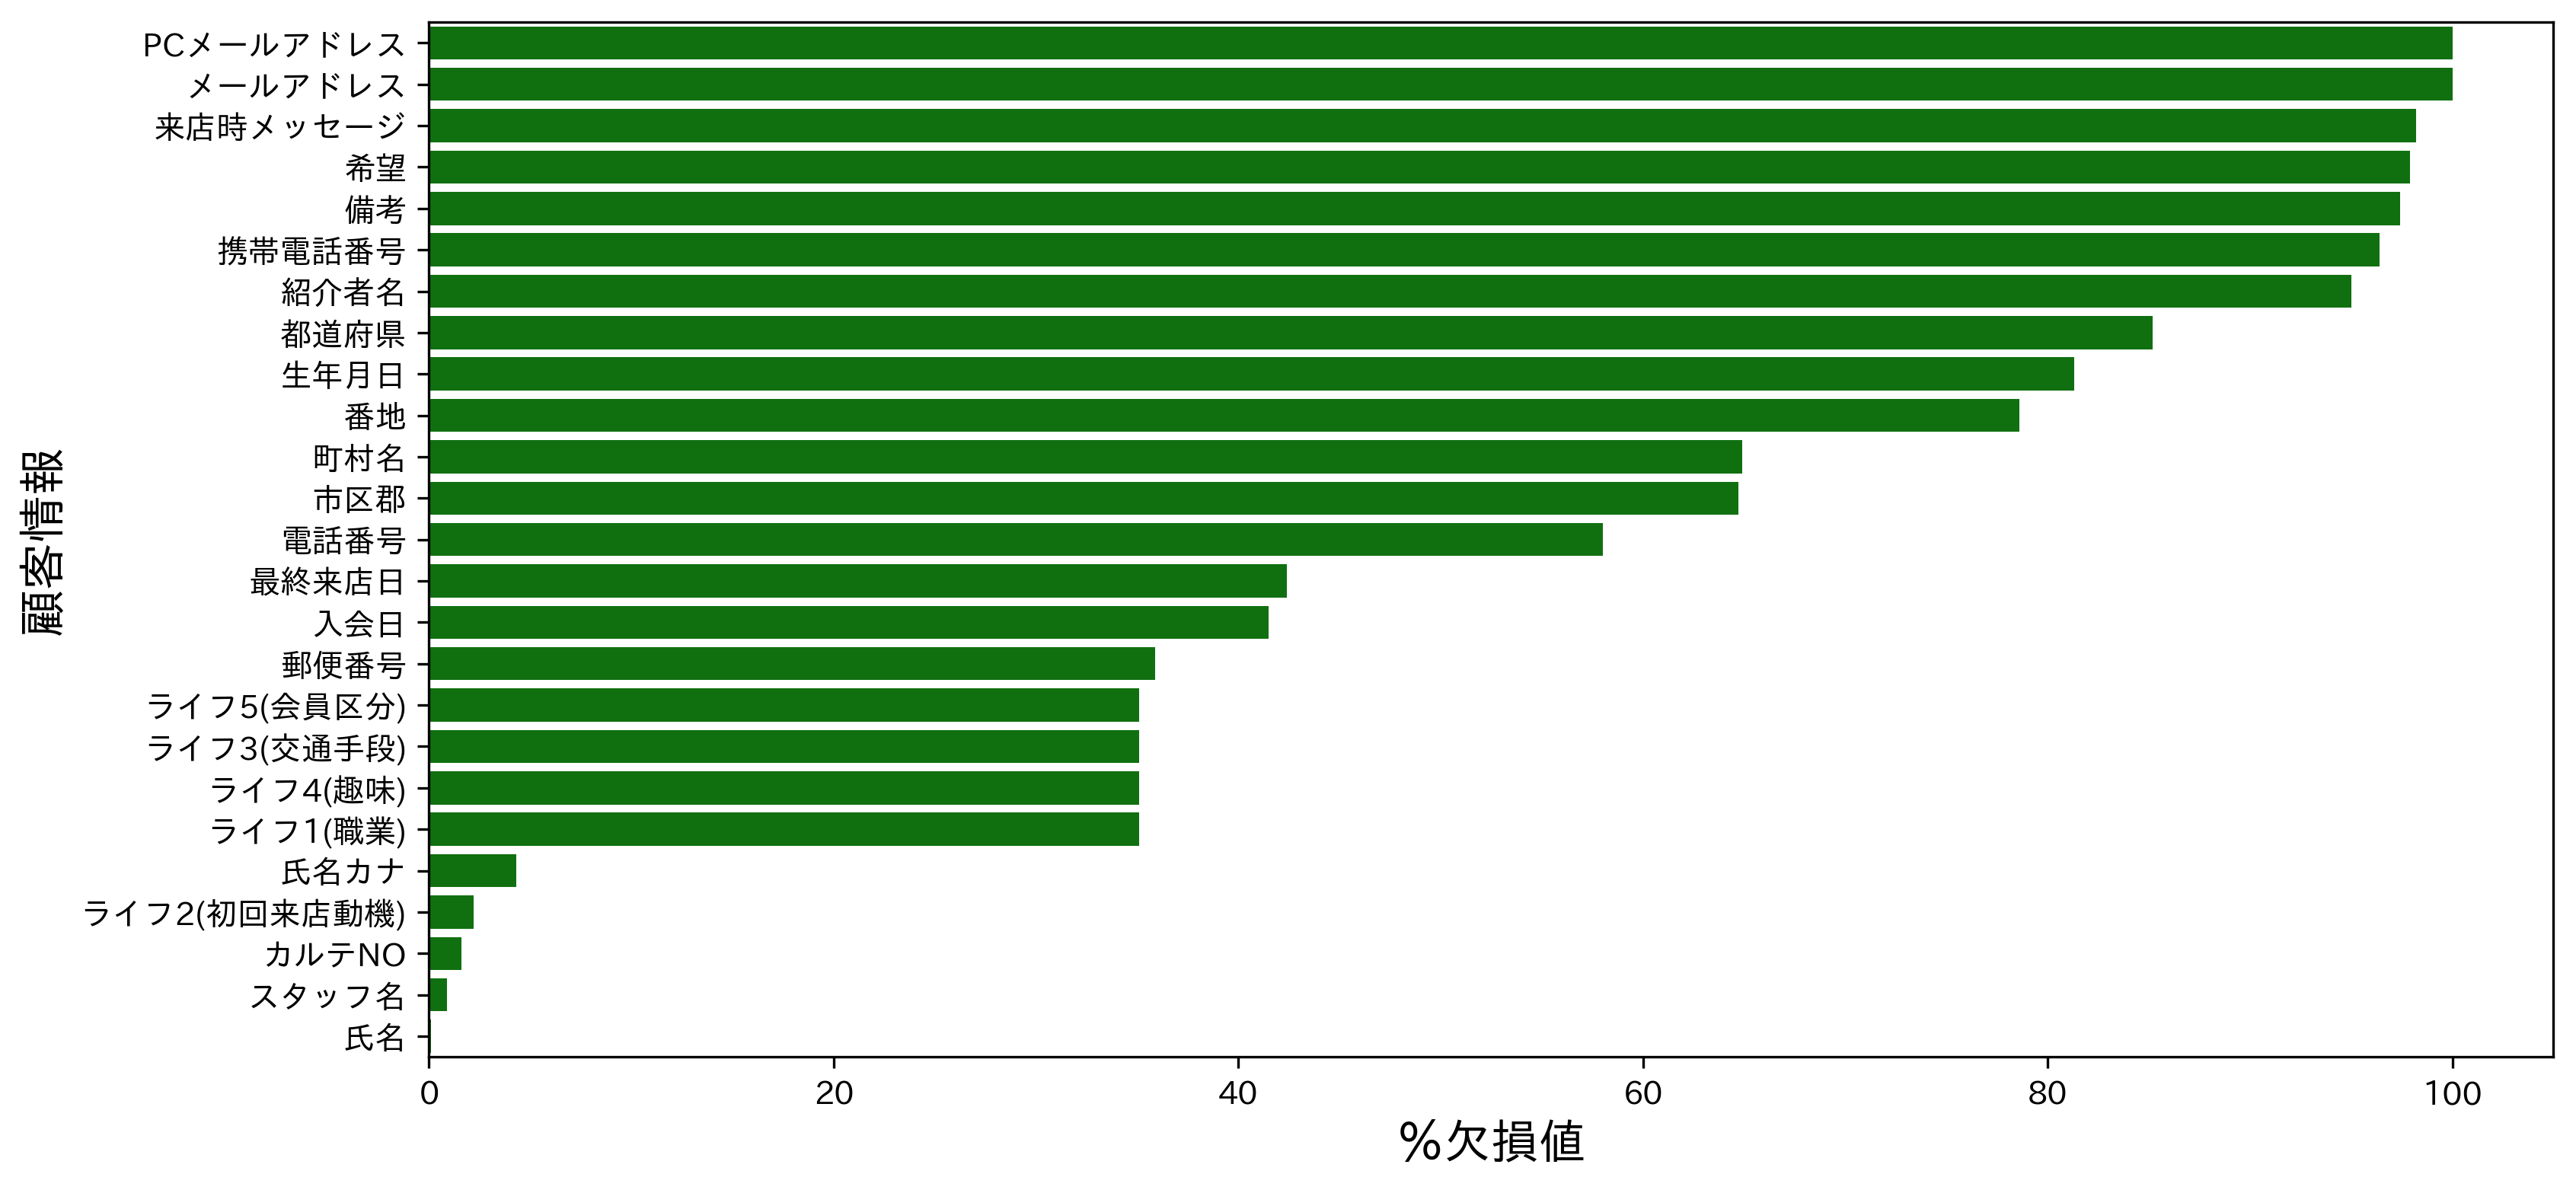

In [8]:
fig,ax = plt.subplots(figsize=(12,6), dpi = 300)
p = sns.barplot(data=df_info_miss, x="% of Total Values", y = df_info_miss.index, color= 'green')
p.set_xlabel("％欠損値", fontsize = 15)
p.set_ylabel("顧客情報", fontsize = 15)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
#plt.xlabel('顧客人数')
plt.show()

## ３．顧客売上データの分析 (新宮店)

In [9]:
df_txn = pd.read_csv(os.path.join(path_data, "store_106_txn_V3.csv"), encoding= "CP932")

/home/zhangmingming/anaconda3/envs/present/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (32) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
df_txn.columns

Index(['売上明細ID', '売上伝票NO', '明細NO', '伝票区分', '店舗ID', '店舗名', '売上日', '会員ID',
       '会員氏名カナ', '会員氏名', 'スタッフID', 'スタッフ名', '指名', '商品大分類ID', '商品大分類名', '商品ID',
       '商品名', '売上部門ID', '売上部門名', '部門', '販売数量', '販売単価', '販売金額', '明細値引金額',
       '合計値引按分額', 'ポイント値引金額', 'プリペイド値引金額', '値引合計金額', '値引本体金額', '本体金額', '消費税',
       '税区分', '値引対象', 'パーセント値引', '値引率', '消費税率', '通常/軽減税率'],
      dtype='object')

In [11]:
df_txn['会員ID'].nunique()

24050

In [12]:
df_txn.columns

Index(['売上明細ID', '売上伝票NO', '明細NO', '伝票区分', '店舗ID', '店舗名', '売上日', '会員ID',
       '会員氏名カナ', '会員氏名', 'スタッフID', 'スタッフ名', '指名', '商品大分類ID', '商品大分類名', '商品ID',
       '商品名', '売上部門ID', '売上部門名', '部門', '販売数量', '販売単価', '販売金額', '明細値引金額',
       '合計値引按分額', 'ポイント値引金額', 'プリペイド値引金額', '値引合計金額', '値引本体金額', '本体金額', '消費税',
       '税区分', '値引対象', 'パーセント値引', '値引率', '消費税率', '通常/軽減税率'],
      dtype='object')

### 3.1．売上毎日データの分析 

In [13]:
df_amt_txn = df_txn.groupby('売上日')['販売金額'].sum().reset_index()

In [14]:
df_amt_txn.min()

売上日     2009/09/01
販売金額          1836
dtype: object

In [15]:
df_amt_txn.max()

売上日     2021/12/31
販売金額        246630
dtype: object

In [16]:
df_amt_txn.head()

,売上日,販売金額
0,2009/09/01,97725
1,2009/09/02,139065
2,2009/09/03,117375
3,2009/09/04,131625
4,2009/09/05,191815


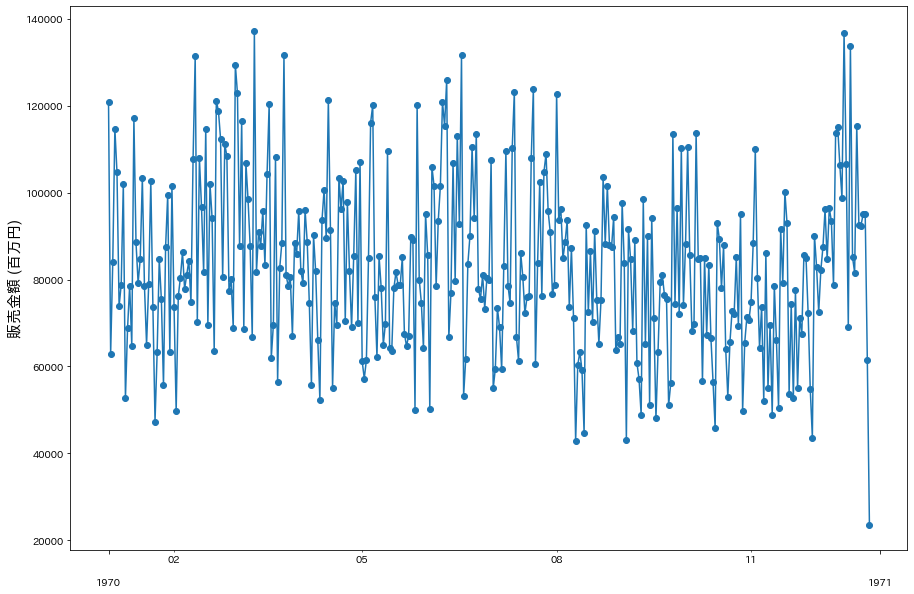

In [17]:
df_amt_txn_graph = df_amt_txn[(df_amt_txn['売上日'] < '2016/01/01')&(df_amt_txn['売上日'] > '2015/01/01')]
# format the fig
years = mdates.YearLocator()
months = mdates.MonthLocator(interval=3)
monthsFmt = mdates.DateFormatter('%m') 
yearsFmt = mdates.DateFormatter('\n\n%Y')  # add some space for the year label

#sns.set_style(style='white')
fig, ax = plt.subplots(figsize = (15,10), facecolor='white')  
#ax.set_facecolor('white')
#fig = sns.barplot(x = "売上月", y = "売上金額", data = df_amt_txn_month, ax=ax, facecolor='blue')
ax.plot_date(df_amt_txn_graph['売上日'].tolist(), df_amt_txn_graph['販売金額'].tolist(), linestyle = 'solid')
#ax.bar(df_amt_txn_month['売上日'].tolist(), df_amt_txn_month['販売金額'].tolist(), width=20)
plt.ylabel('販売金額 (百万円)', fontsize = 15)
ax.xaxis_date()
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(monthsFmt)
#plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)

### 3.2．売上毎月データの分析

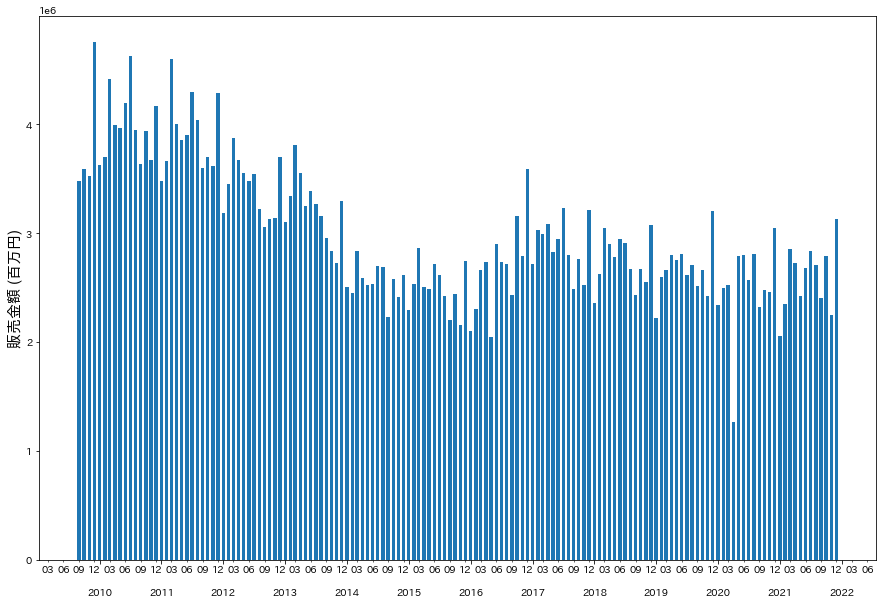

In [18]:
df_amt_txn.loc[:,'売上月'] = df_amt_txn.apply(lambda x: date(datetime.strptime(x['売上日'], '%Y/%m/%d').year, datetime.strptime(x['売上日'], '%Y/%m/%d').month, 1),axis = 1)
df_amt_txn_month = df_amt_txn.groupby('売上月')['販売金額'].sum().reset_index()

# format the fig
years = mdates.YearLocator()
months = mdates.MonthLocator(interval=3)
monthsFmt = mdates.DateFormatter('%m') 
yearsFmt = mdates.DateFormatter('\n\n%Y')  # add some space for the year label

#sns.set_style(style='white')
fig, ax = plt.subplots(figsize = (15,10), facecolor='white')  
#ax.set_facecolor('white')
#fig = sns.barplot(x = "売上月", y = "売上金額", data = df_amt_txn_month, ax=ax, facecolor='blue')
#ax.plot_date(df_amt_txn_month['売上月'].tolist(), df_amt_txn_month['売上金額'].tolist(), linestyle = 'solid')
ax.bar(df_amt_txn_month['売上月'].tolist(), df_amt_txn_month['販売金額'].tolist(), width=20)
plt.ylabel('販売金額 (百万円)', fontsize = 15)
ax.xaxis_date()
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(monthsFmt)
#plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)

### 3.3．月別売上製品種類についての分析

In [19]:
df_txn.columns

Index(['売上明細ID', '売上伝票NO', '明細NO', '伝票区分', '店舗ID', '店舗名', '売上日', '会員ID',
       '会員氏名カナ', '会員氏名', 'スタッフID', 'スタッフ名', '指名', '商品大分類ID', '商品大分類名', '商品ID',
       '商品名', '売上部門ID', '売上部門名', '部門', '販売数量', '販売単価', '販売金額', '明細値引金額',
       '合計値引按分額', 'ポイント値引金額', 'プリペイド値引金額', '値引合計金額', '値引本体金額', '本体金額', '消費税',
       '税区分', '値引対象', 'パーセント値引', '値引率', '消費税率', '通常/軽減税率'],
      dtype='object')

/home/zhangmingming/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


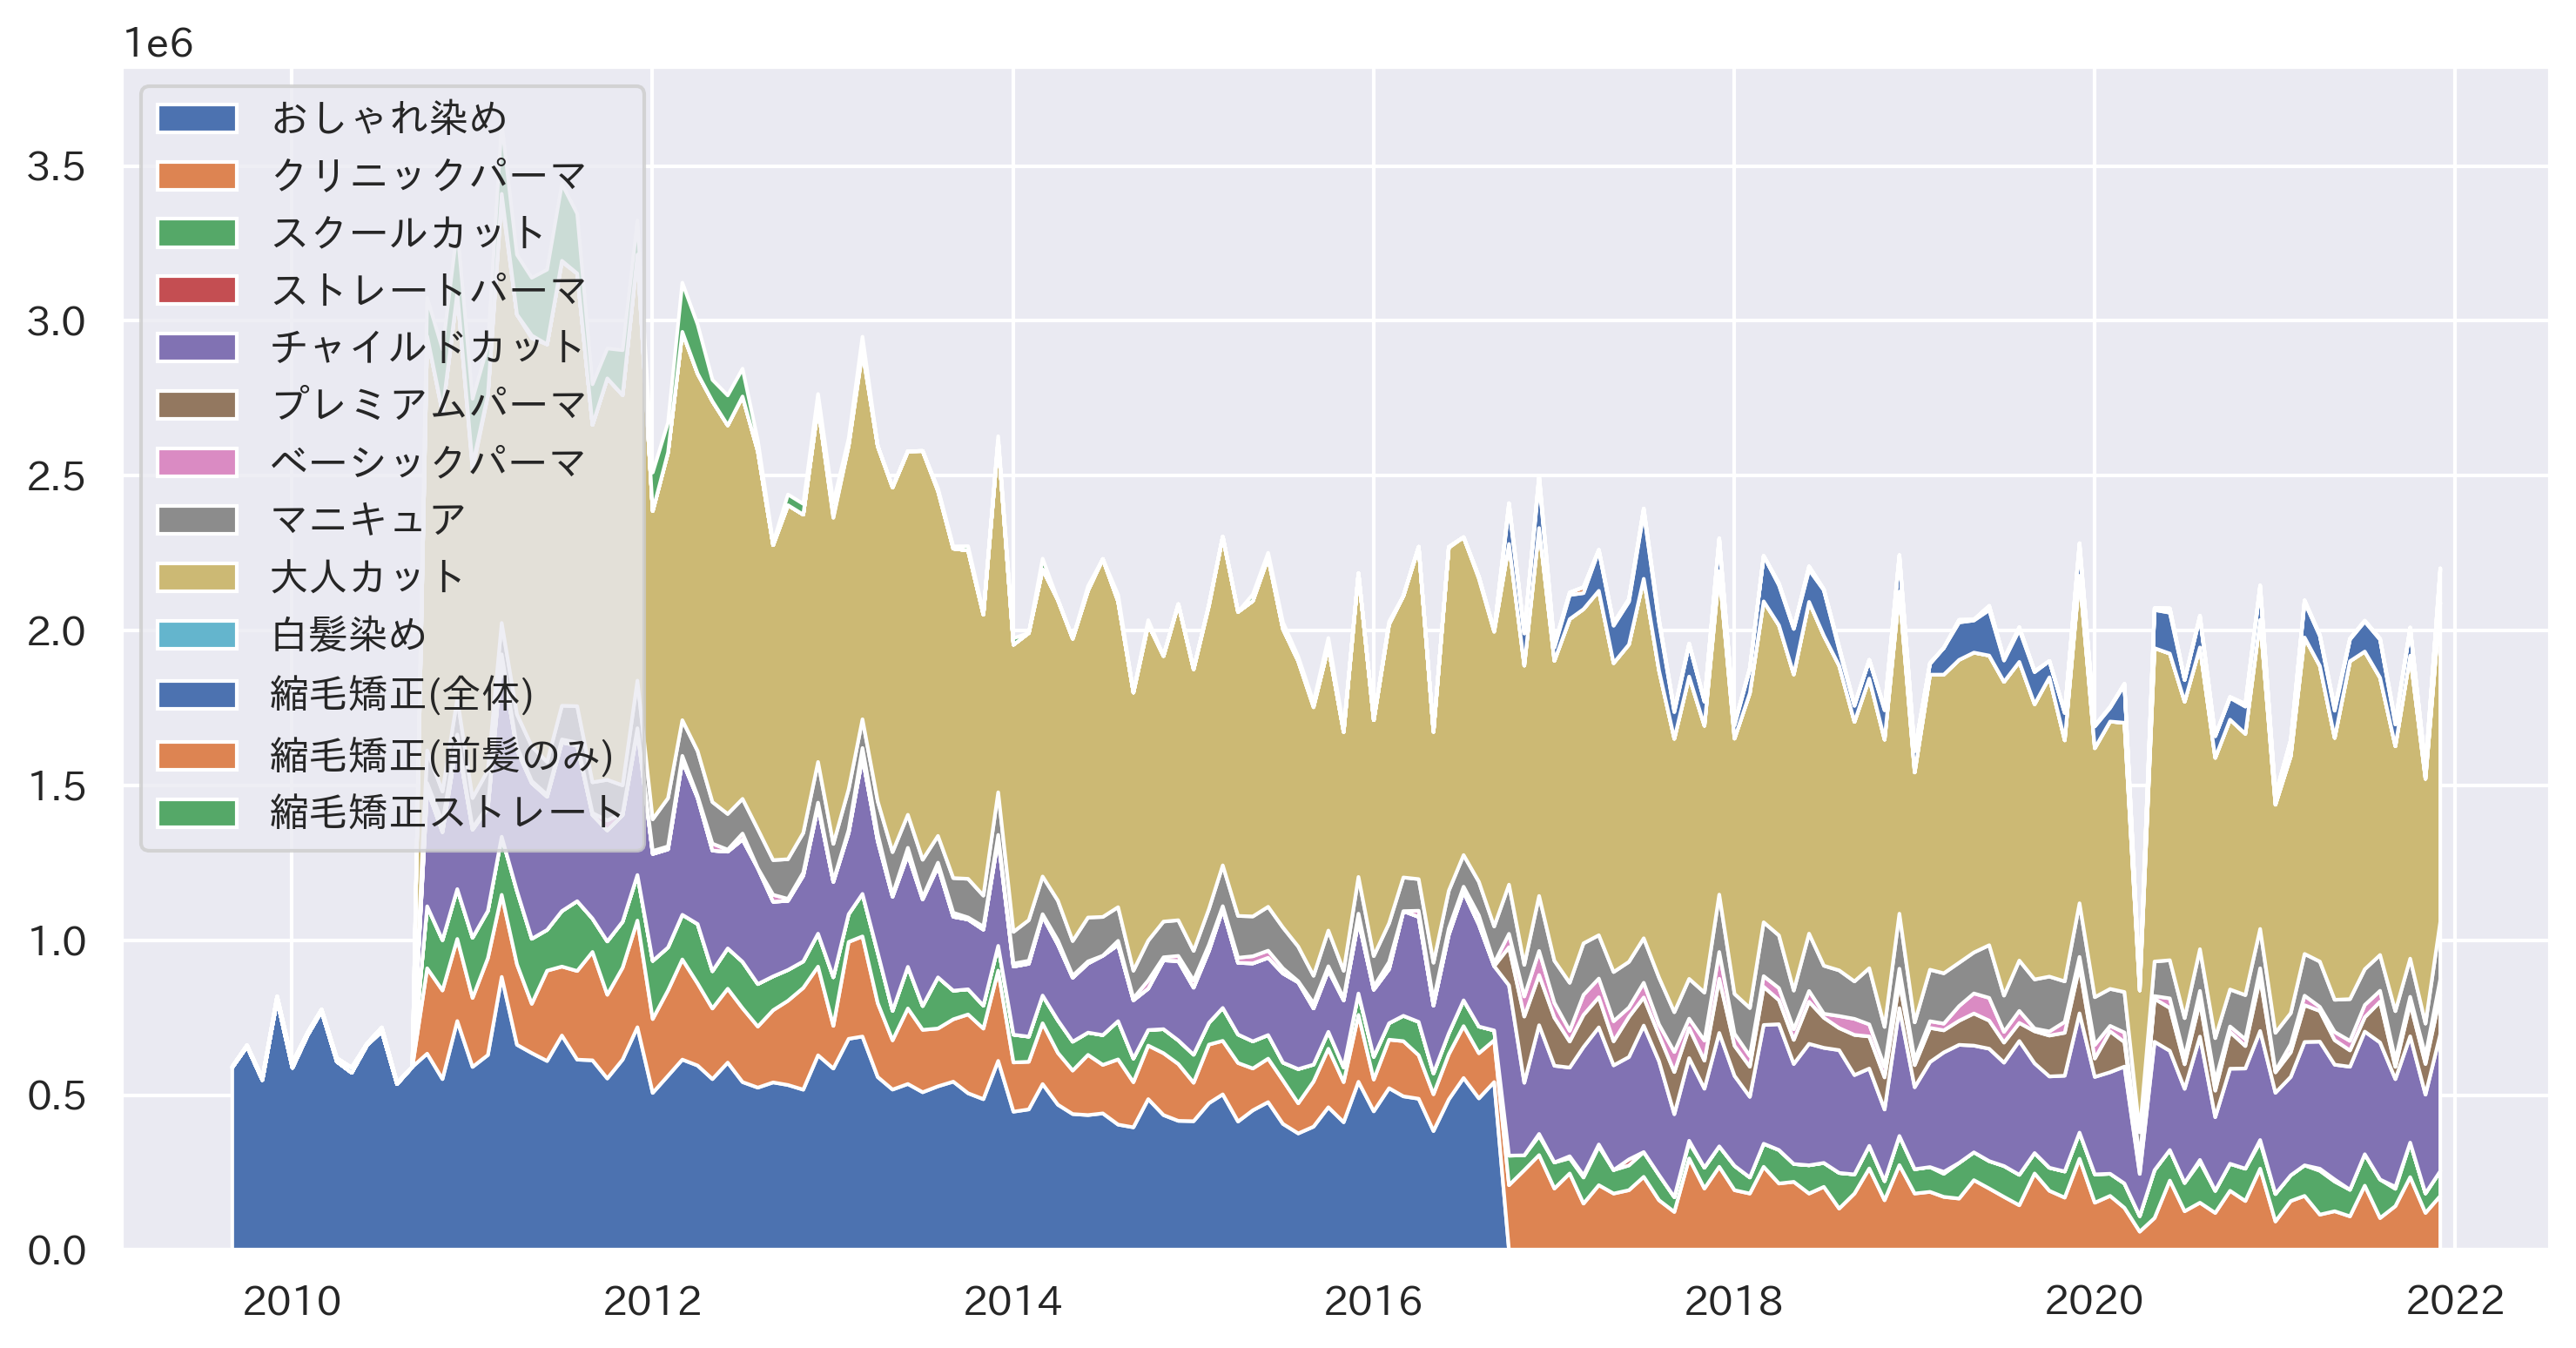

In [20]:
'''
# search for the product names
ls_product = df_txn['商品名'].unique().tolist()
for prod in ls_product:
    try:
        if '縮毛矯正' in prod:
            print(prod)
    except:
        pass
'''

# select product list
ls_prod = ['縮毛矯正ストレート','縮毛矯正(全体)','縮毛矯正(前髪のみ)','スクールカット','大人カット','チャイルドカット', '白髪染め', 'おしゃれ染め','マニキュア', 'ベーシックパーマ', 'クリニックパーマ',  'プレミアムパーマ', 'ストレートパーマ']
df_txn_part = df_txn[df_txn['商品名'].isin(ls_prod)]

# create pivot table for demostration
df_txn_part.loc[:, '売上月'] = df_txn_part.apply(lambda x: date(datetime.strptime(x['売上日'], '%Y/%m/%d').year, datetime.strptime(x['売上日'], '%Y/%m/%d').month, 1),axis = 1)
df_txn_part_pivot = pd.pivot_table(df_txn_part, values='販売金額', index=['売上月'], columns=['商品名'], aggfunc=np.sum, fill_value=0)

sns.set_theme()
sns.set(font_scale = 1, font = 'IPAexGothic')
fig,ax = plt.subplots(figsize=(12,6), dpi = 300)
plt.stackplot(df_txn_part_pivot.index.tolist(),df_txn_part_pivot.to_numpy().transpose(1,0), labels=df_txn_part_pivot.columns.values)
plt.legend(loc='upper left')
#plt.ylim((0,20000))
plt.show()

### 3.4．月別新規顧客の分析

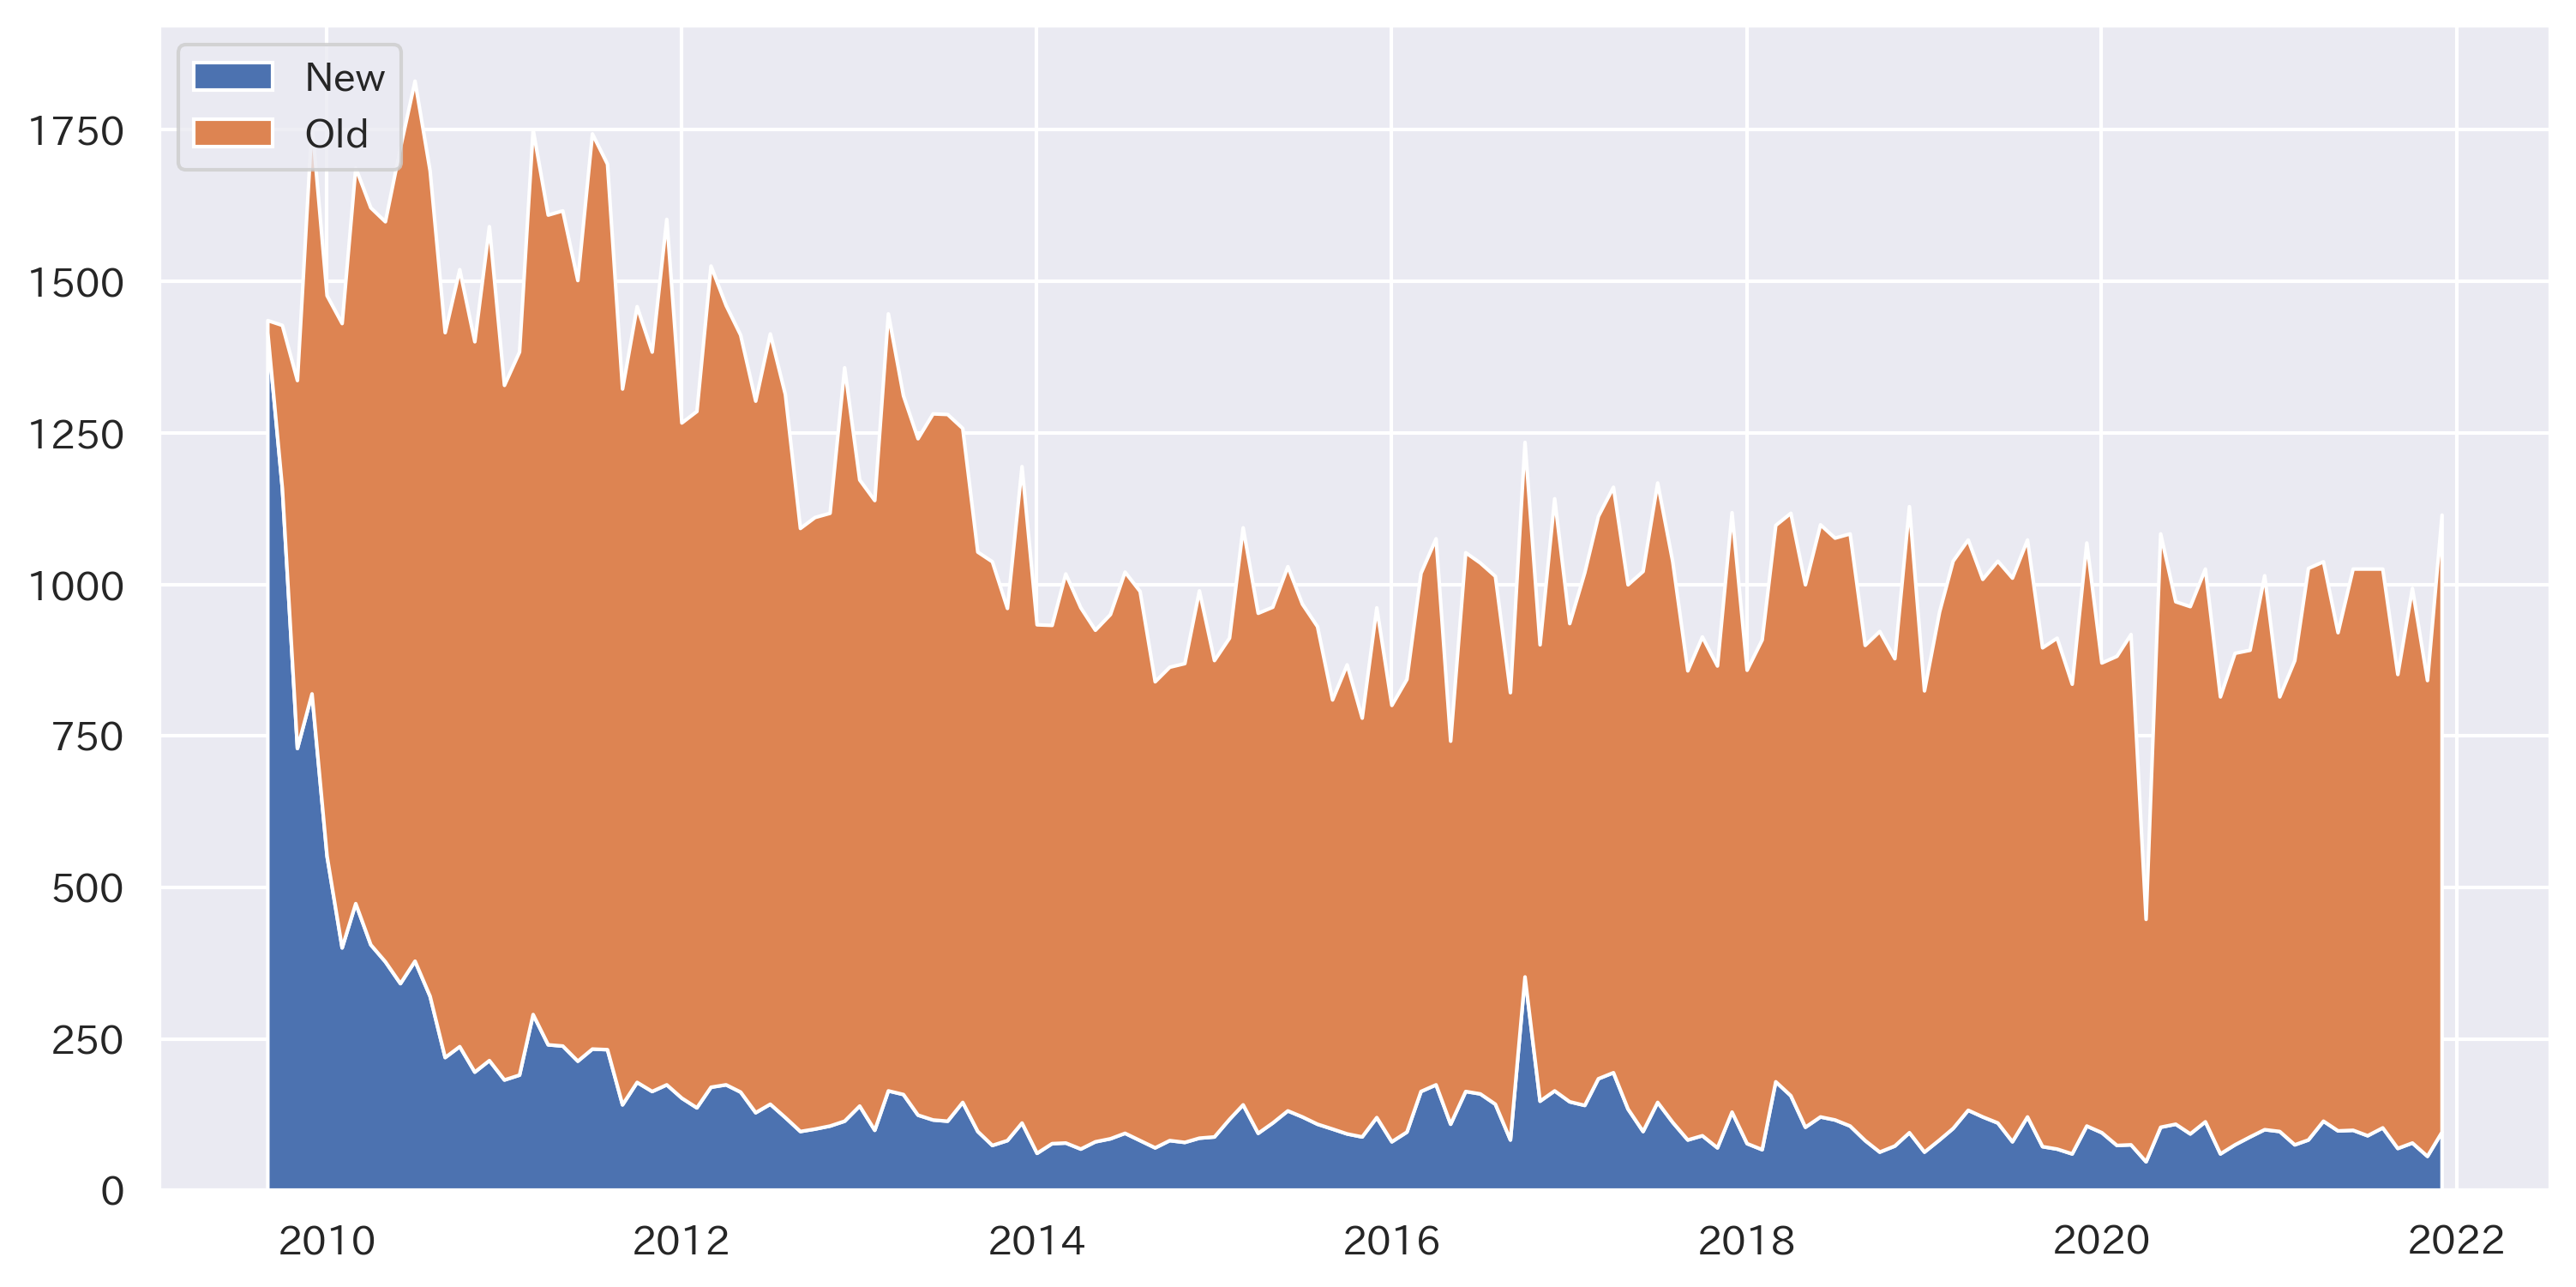

In [21]:
df_cust_first = df_cust[['会員ID', '入会日']]
df_txn_daily = df_txn[['会員ID','売上日']].drop_duplicates()
df_txn_daily_ON = df_txn_daily.merge(df_cust_first, on = '会員ID', how = 'left')
df_txn_daily_ON.loc[:, 'VisitType'] =  df_txn_daily_ON.apply(lambda x: 'New' if re.match('^\d{4}/\d{2}/\d{2}$', str(x['入会日'])) and x['入会日'] == x['売上日'] else 'Old', axis = 1)

df_txn_daily_ON.loc[:, '売上月'] = df_txn_daily_ON.apply(lambda x: date(datetime.strptime(x['売上日'], '%Y/%m/%d').year, datetime.strptime(x['売上日'], '%Y/%m/%d').month, 1),axis = 1)
df_txn_daily_ON_pivot = pd.pivot_table(df_txn_daily_ON, values='会員ID', index=['売上月'], columns=['VisitType'], aggfunc=pd.Series.nunique, fill_value=0)

#sns.set_theme()
fig,ax = plt.subplots(figsize=(12,6), dpi = 300)
plt.stackplot(df_txn_daily_ON_pivot.index.tolist(),df_txn_daily_ON_pivot.to_numpy().transpose(1,0), labels=df_txn_daily_ON_pivot.columns.values)
plt.legend(loc='upper left')
#plt.ylim((0,20000))
plt.show()

In [22]:
df_txn_daily_ON_pivot['New'].mean()

161.75

### 3.5. 顧客売上高の分析

In [23]:
df_txn_amt = df_txn[['会員ID', '売上日', '販売金額', '値引合計金額']]
df_txn_amt.loc[:, 'Amount']  = df_txn_amt['販売金額'] - df_txn_amt['値引合計金額']
df_txn_amt_cust = df_txn_amt.groupby('会員ID')['Amount'].sum().reset_index()
df_txn_amt_cust.loc[:,'pct_rank_amt'] = df_txn_amt_cust['Amount'] / df_txn_amt_cust['Amount'].max()

### 3.6. 顧客売上高の分析

In [24]:
df_txn_freq = df_txn[['会員ID', '売上日']]
df_txn_freq_cust = df_txn_freq.groupby('会員ID')['売上日'].nunique().reset_index(name = 'freq')
df_txn_freq_cust.loc[:,'pct_rank_freq'] = df_txn_freq_cust['freq'] / df_txn_freq_cust['freq'].max()

In [25]:
df_txn_freq_cust.head()

,会員ID,freq,pct_rank_freq
0,6000001,6,0.032967
1,6000004,12,0.065934
2,6000006,13,0.071429
3,6000008,2,0.010989
4,6000018,16,0.087912


## 4. 日付の差の分析

In [26]:
df_txn_daily.loc[:, '売上日前回'] = df_txn_daily.groupby('会員ID')['売上日'].shift(1)
df_txn_daily.dropna(inplace = True)

In [27]:
df_txn_daily['会員ID'].nunique()

14870

In [28]:
df_txn_daily.loc[:, '日付の差'] = df_txn_daily.apply(lambda x: (datetime.strptime(x['売上日'], '%Y/%m/%d') - datetime.strptime(x['売上日前回'], '%Y/%m/%d') ).days, axis = 1)

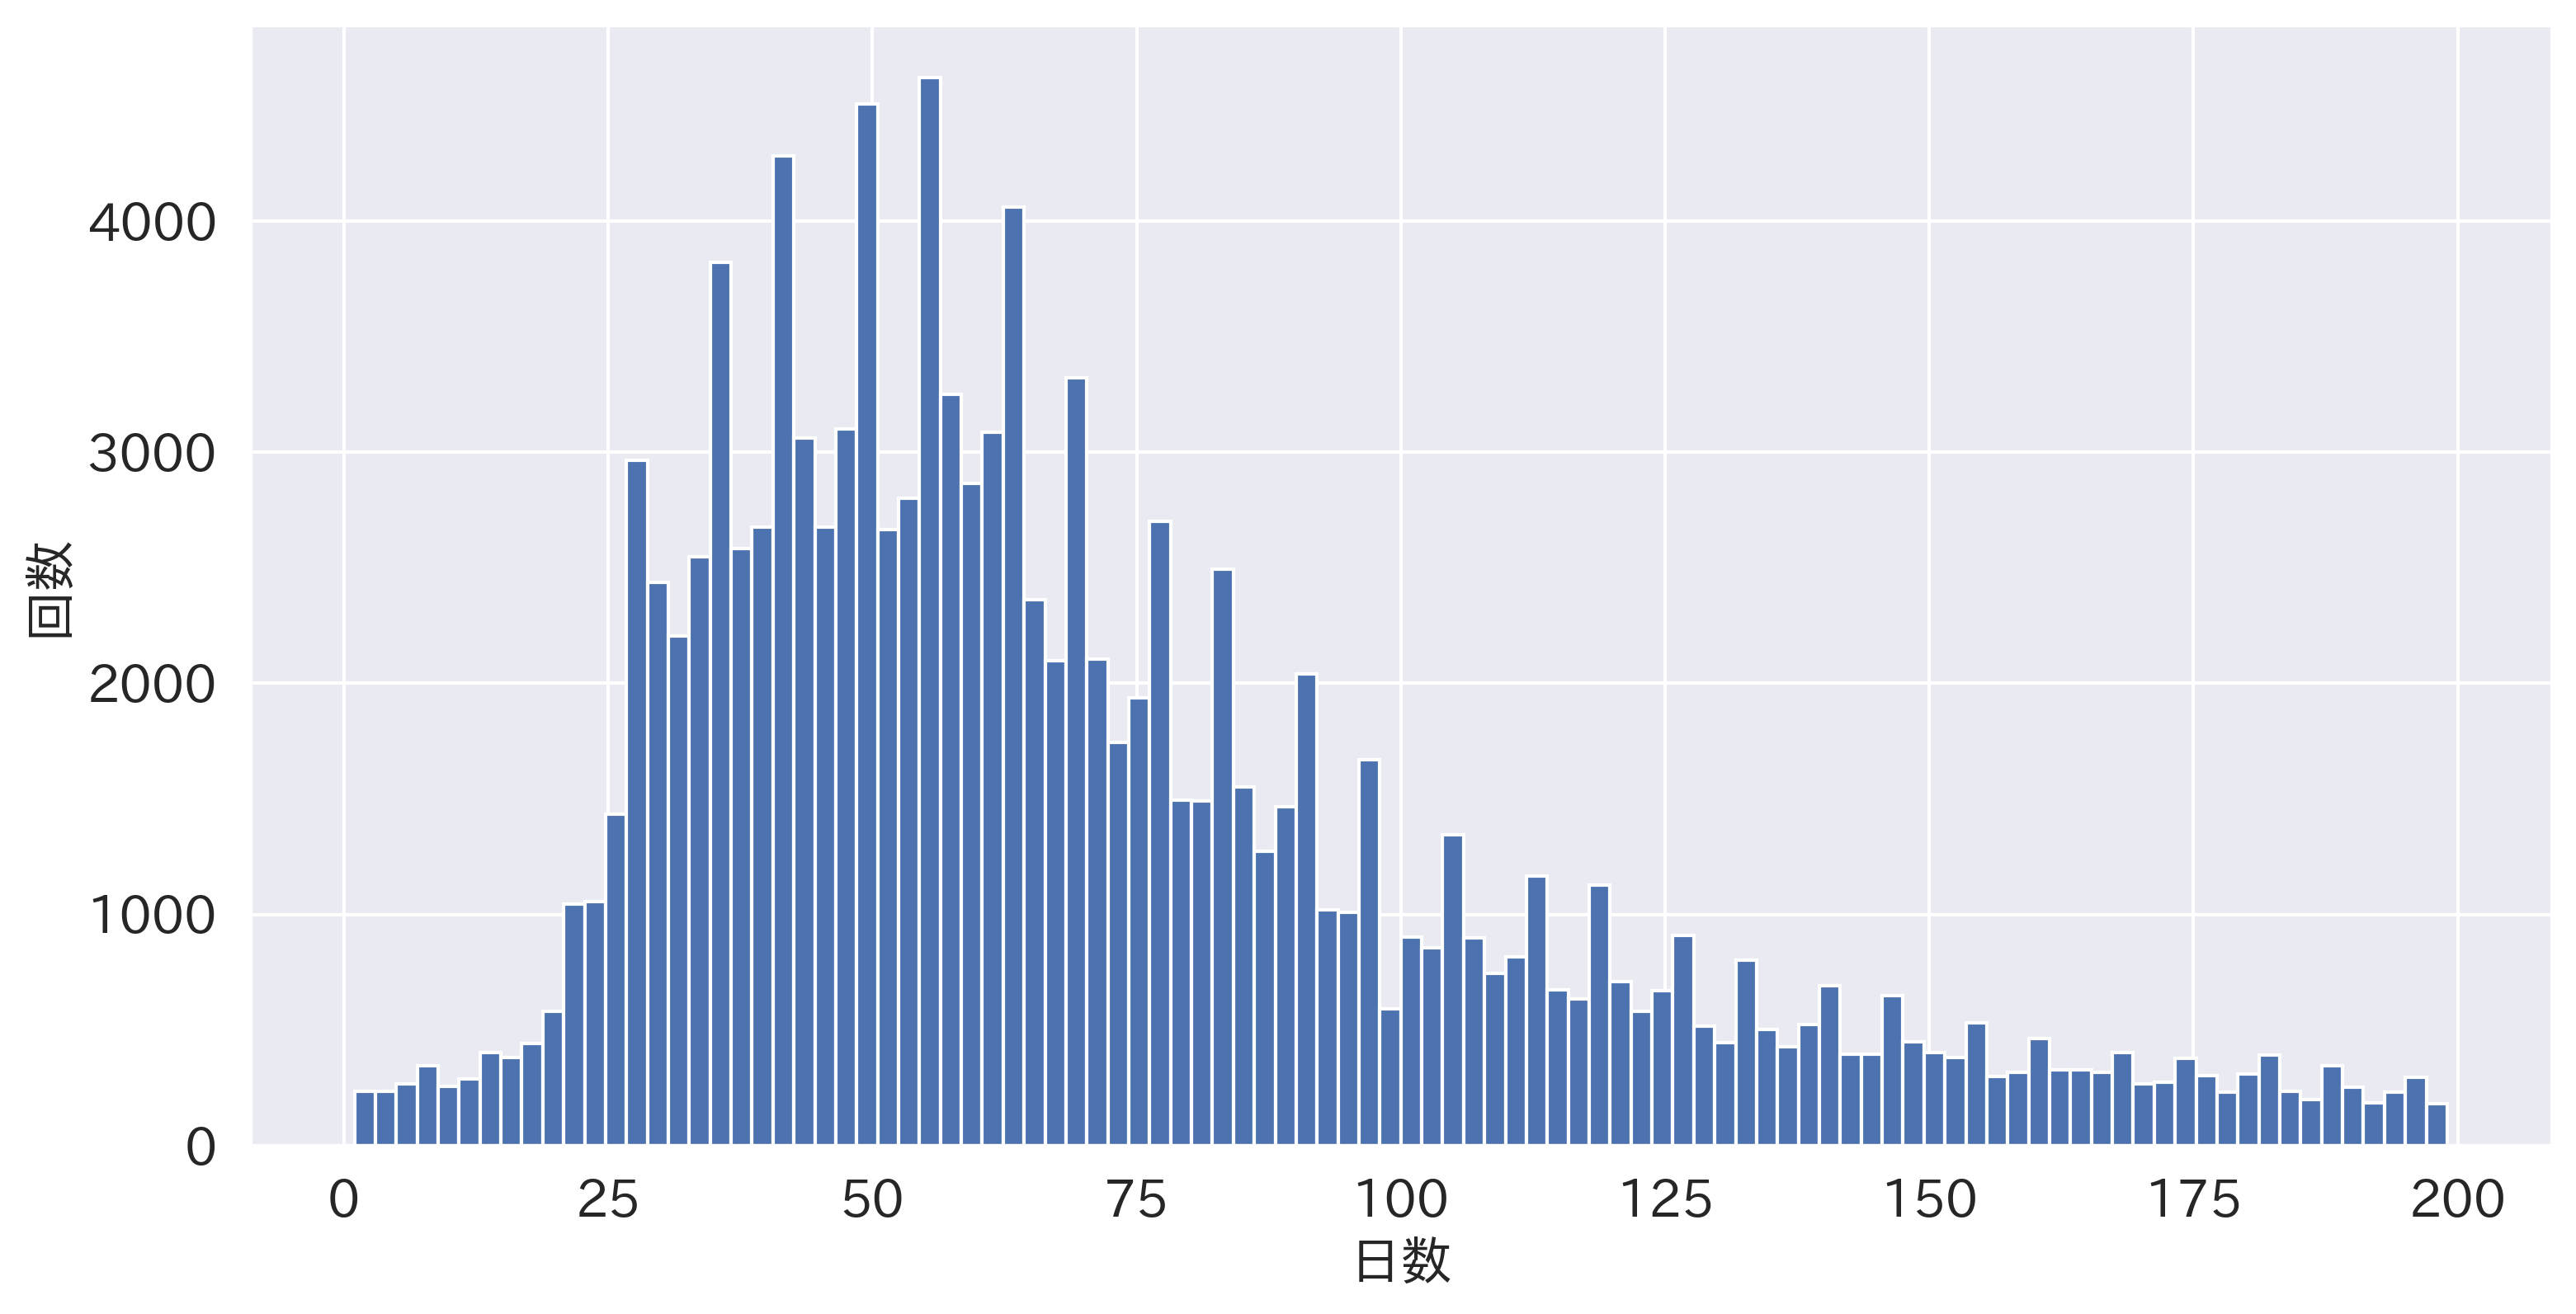

In [29]:
fig,ax = plt.subplots(figsize=(12,6), dpi = 300)
plt.hist(df_txn_daily[df_txn_daily['日付の差'] < 200]['日付の差'].tolist(), bins=100)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('日数', fontsize = 15)
plt.ylabel('回数', fontsize = 15)
plt.show()

## ５．顧客画像の分析

In [30]:
df_cust.columns

Index(['会員ID', '会員BC', 'カルテNO', '店舗ID', '店舗名', '氏名カナ', '氏名', '性別', '郵便番号',
       '都道府県', '市区郡', '町村名', '番地', '生年月日', '年齢', '会員ポイント数', 'スタッフID', 'スタッフ名',
       'ライフ1ID', 'ライフ1(職業)', 'ライフ2ID', 'ライフ2(初回来店動機)', 'ライフ3ID', 'ライフ3(交通手段)',
       'ライフ4ID', 'ライフ4(趣味)', 'ライフ5ID', 'ライフ5(会員区分)', '電話番号', '携帯電話番号',
       'メールアドレス', 'PCメールアドレス', 'DM発送可否', '自動メール受信可否', '有効/削除', '入会日', '最終来店日',
       '来店回数', '紹介者ID', '紹介者名', '備考', '希望', '来店時メッセージ使用可否', '来店時メッセージ'],
      dtype='object')

### 5.1 第一層： recognition & contact

In [31]:
#  第一層： recognition & contact
#　日本の携帯電話は全部「070, 080, 090 」、電話は別な電話番号
#　日本のアドレスのルールを勉強しました：都道府県ー＞市区郡ー＞町村名ー＞番地
df_cust['DM発送可否'].value_counts()
df_cust_profile_t1 = df_cust[['会員ID','電話番号', '携帯電話番号','氏名','氏名カナ','メールアドレス','PCメールアドレス','郵便番号', '番地', 'DM発送可否']]
df_cust_profile_t1.loc[:,'Phone'] = df_cust_profile_t1.apply(lambda x : pd.notnull(x['電話番号']) or pd.notnull(x['携帯電話番号']),axis =1 )
df_cust_profile_t1.loc[:,'Name'] = df_cust_profile_t1['氏名']
df_cust_profile_t1.loc[:,'Email'] = df_cust_profile_t1.apply(lambda x : pd.notnull(x['メールアドレス']) or pd.notnull(x['PCメールアドレス']),axis =1 )
df_cust_profile_t1.loc[:,'Mail'] = df_cust_profile_t1.apply(lambda x : pd.notnull(x['番地']) and x['DM発送可否']=='可',axis =1 )
df_cust_profile_t1 = df_cust_profile_t1[['会員ID', 'Phone', 'Name', 'Email', 'Mail']]

/home/zhangmingming/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [32]:
df_cust_profile_t1.shape

(42089, 5)

In [33]:
df_cust_profile_t1.head()

,会員ID,Phone,Name,Email,Mail
0,6000001,True,田中 康枝,False,True
1,6000002,True,平野 かおる,False,True
2,6000003,True,岩崎 昌子,False,True
3,6000004,True,今林 はるみ,False,True
4,6000005,True,田代 秀子,False,True


### 5.2 第二層： Demographics

In [34]:
df_cust_profile_t2 = df_cust[['会員ID','年齢', '生年月日','性別','ライフ1ID', 'ライフ1(職業)']]
df_cust_profile_t2.loc[:,'Age'] = df_cust_profile_t2.apply(lambda x : x['年齢'] if pd.notnull(x['生年月日']) and pd.notnull(x['年齢']) else np.nan,axis =1 )
df_cust_profile_t2.loc[:,'Gender'] = df_cust_profile_t2['性別']
df_cust_profile_t2.loc[:,'Job'] = df_cust_profile_t2.apply(lambda x : x['ライフ1(職業)'] if pd.notnull(x['ライフ1ID']) else np.nan,axis =1 )
df_cust_profile_t2 = df_cust_profile_t2[['会員ID', 'Age', 'Gender', 'Job']]

/home/zhangmingming/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [35]:
df_cust_profile_t2.head()

,会員ID,Age,Gender,Job
0,6000001,50.0,女,その他
1,6000002,42.0,女,その他
2,6000003,56.0,女,その他
3,6000004,56.0,女,その他
4,6000005,49.0,女,その他


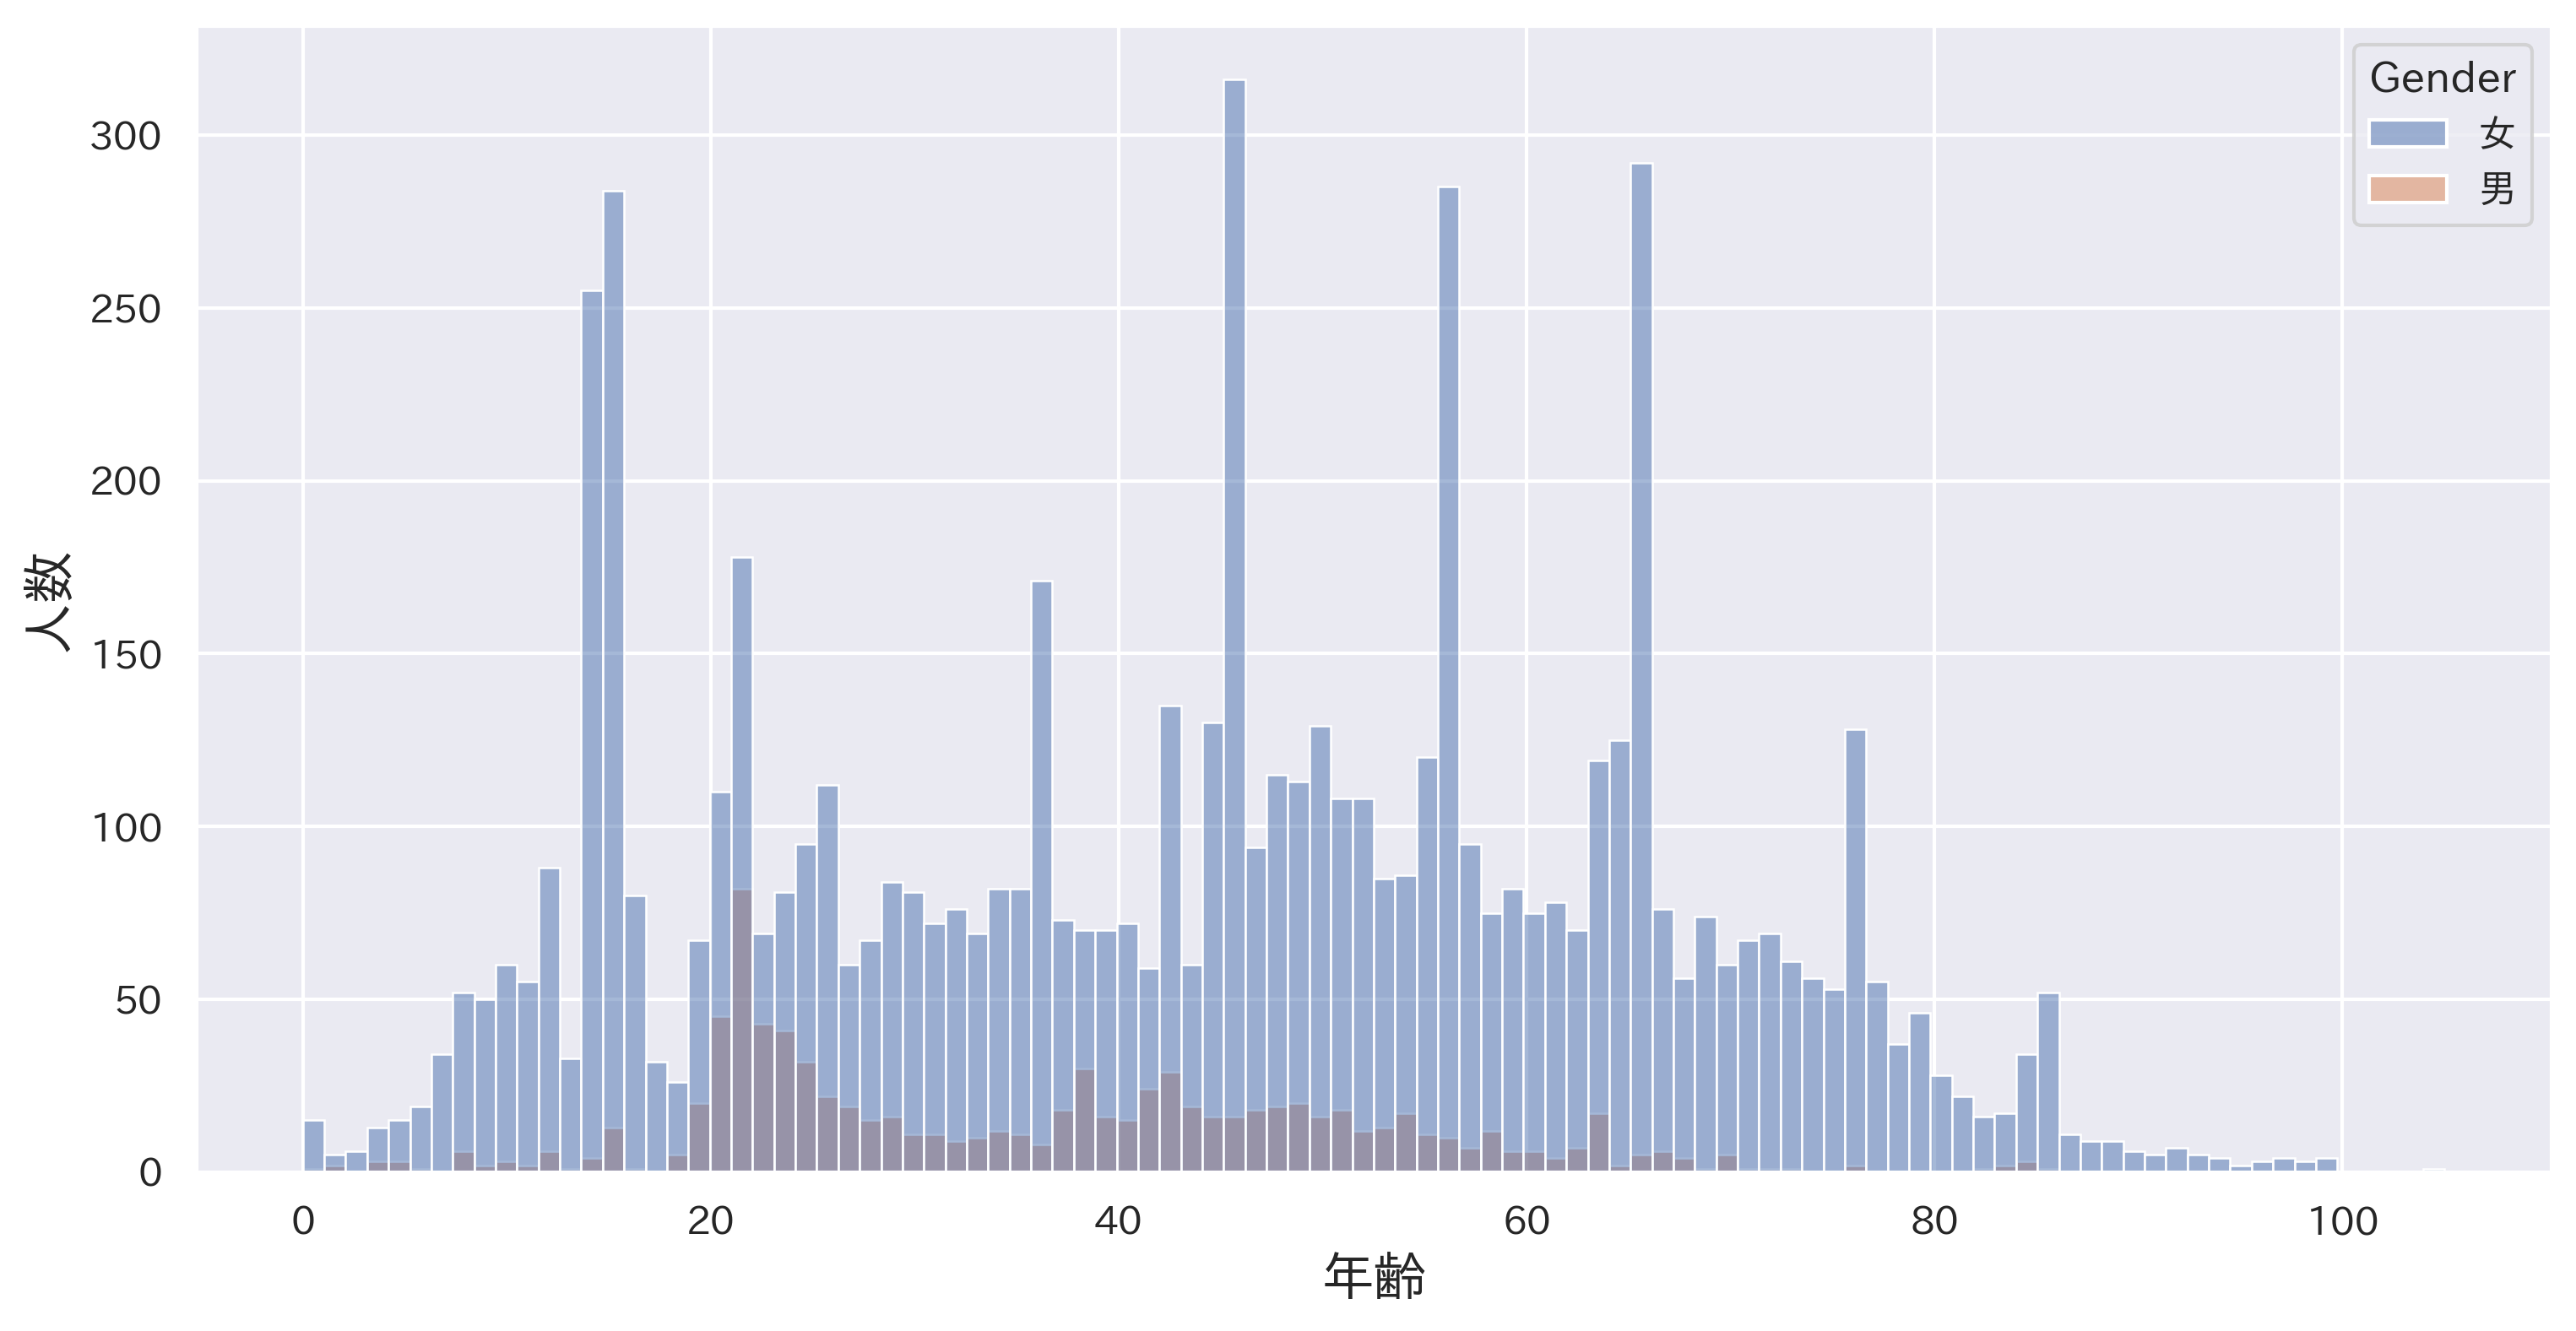

In [36]:
fig,ax = plt.subplots(figsize=(12,6), dpi = 300)
sns.histplot(data=df_cust_profile_t2, x="Age", bins=100, hue = 'Gender')
plt.ylabel('人数', fontsize = 15)
plt.xlabel('年齢', fontsize = 15)
plt.show()

In [37]:
df_cust_profile_t2['Job'].value_counts().reset_index()

,index,Job
0,その他,27054
1,専業主婦,76
2,子 供,72
3,学 生,44
4,会社員・ＯＬ,35
5,主婦パート,16
6,アルバイト,2
7,自由業,2


### 5.3 第三層： Geographic

In [38]:
postman = Jusho()
def location(x):
    # return value 
    res = dict()
    
    # current info
    post_code = x['郵便番号']
    province  = x['都道府県']
    area      = x['市区郡']
    town      = x['町村名']
    room      = x['番地']
    
    # info from postcode
    if pd.notnull(post_code):
        try:
            info_loc         = postman.from_postal_code(post_code) 
            prefecture_kanji = info_loc.prefecture_kanji
            city_kanji       = info_loc.city_kanji
            town_area_kanji  = info_loc.town_area_kanji
        except:
            prefecture_kanji = ''
            city_kanji = ''
            town_area_kanji = ''
        # make return value 
        res['Province'] = prefecture_kanji
        res['City'] = city_kanji
        res['Town'] = town_area_kanji
    else:
        # make return value 
        res['Province'] = np.nan
        res['City'] = np.nan
        res['Town'] = np.nan
    
    # return value 
    return res
df_cust_profile_t3 = df_cust[['会員ID', '郵便番号', '都道府県', '市区郡','町村名', '番地']]
df_cust_profile_t3.loc[:, ['Province', 'City', 'Town']] = df_cust_profile_t3.apply(lambda x : location(x) ,axis =1 , result_type ='expand')
df_cust_profile_t3.loc[:, 'PostCode'] = df_cust_profile_t3['郵便番号']
df_cust_profile_t3 = df_cust_profile_t3[['会員ID', 'Province', 'City', 'Town', 'PostCode']]

/home/zhangmingming/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1884: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)
/home/zhangmingming/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [39]:
df_cust_profile_t3.head()

,会員ID,Province,City,Town,PostCode
0,6000001,福岡県,糟屋郡新宮町,湊,8110116
1,6000002,福岡県,福岡市東区,和白東,8110214
2,6000003,福岡県,福岡市東区,三苫,8110201
3,6000004,福岡県,福岡市東区,雁の巣,8110206
4,6000005,福岡県,福岡市東区,唐原,8130001


## ６．顧客の初めのクラスタリング

### ６．１　会員の売上数の統計

In [40]:
# 会員の売上数の統計
df_txn_user_cnt_txn = df_txn_daily.groupby('会員ID').size().reset_index(name = '売上数')

# 売上数の会員の人数統計
df_user_txns = df_txn_user_cnt_txn['売上数'].value_counts().reset_index(name = '人数')
df_user_txns.rename(columns={'index':'来店数'}, inplace = True)

# 最後の売上時間
df_txn_daily_date_last = df_txn_daily.groupby('会員ID')['売上日'].max().reset_index()

# 200日以上で再来店しないなら
date_last = (date(2021, 12, 31) - timedelta(days = 200)).strftime('%Y/%m/%d')

# 再来店率を計算します
ls_ratio_transition = []
for i in range(1, 20):
    df_txn_user_cnt_txn_tx = df_txn_user_cnt_txn[df_txn_user_cnt_txn['売上数'] == i].merge(df_txn_daily_date_last, on = '会員ID', how = 'left')
    df_txn_user_cnt_txn_tx = df_txn_user_cnt_txn_tx[df_txn_user_cnt_txn_tx['売上日'] <= date_last]
    cnt_2nd = df_user_txns[df_user_txns['来店数'] > i]['人数'].sum()
    #ratio = df_txn_user_cnt_txn_tx.shape[0] / (df_txn_user_cnt_txn_tx.shape[0] + cnt_2nd) * 100.0
    ratio = cnt_2nd / (df_txn_user_cnt_txn_tx.shape[0] + cnt_2nd) * 100.0
    ls_ratio_transition.append(ratio)
    #print(f'第{i}回から第{i+1}回の来店率：{ratio}%')
    print(f'第{i}回から率：{ratio}%')

第1回から率：79.33091108521286%
第2回から率：84.41168682143172%
第3回から率：87.38029367950628%
第4回から率：88.94391481985886%
第5回から率：89.96035117530444%
第6回から率：91.10291760179545%
第7回から率：91.53363228699551%
第8回から率：92.4%
第9回から率：93.08217669090108%
第10回から率：93.01036394311882%
第11回から率：94.22163588390501%
第12回から率：94.22362024592508%
第13回から率：94.61300309597523%
第14回から率：93.93333333333334%
第15回から率：94.38242707958229%
第16回から率：94.12908242612752%
第17回から率：94.98525073746312%
第18回から率：95.98012646793134%
第19回から率：95.79148732663796%


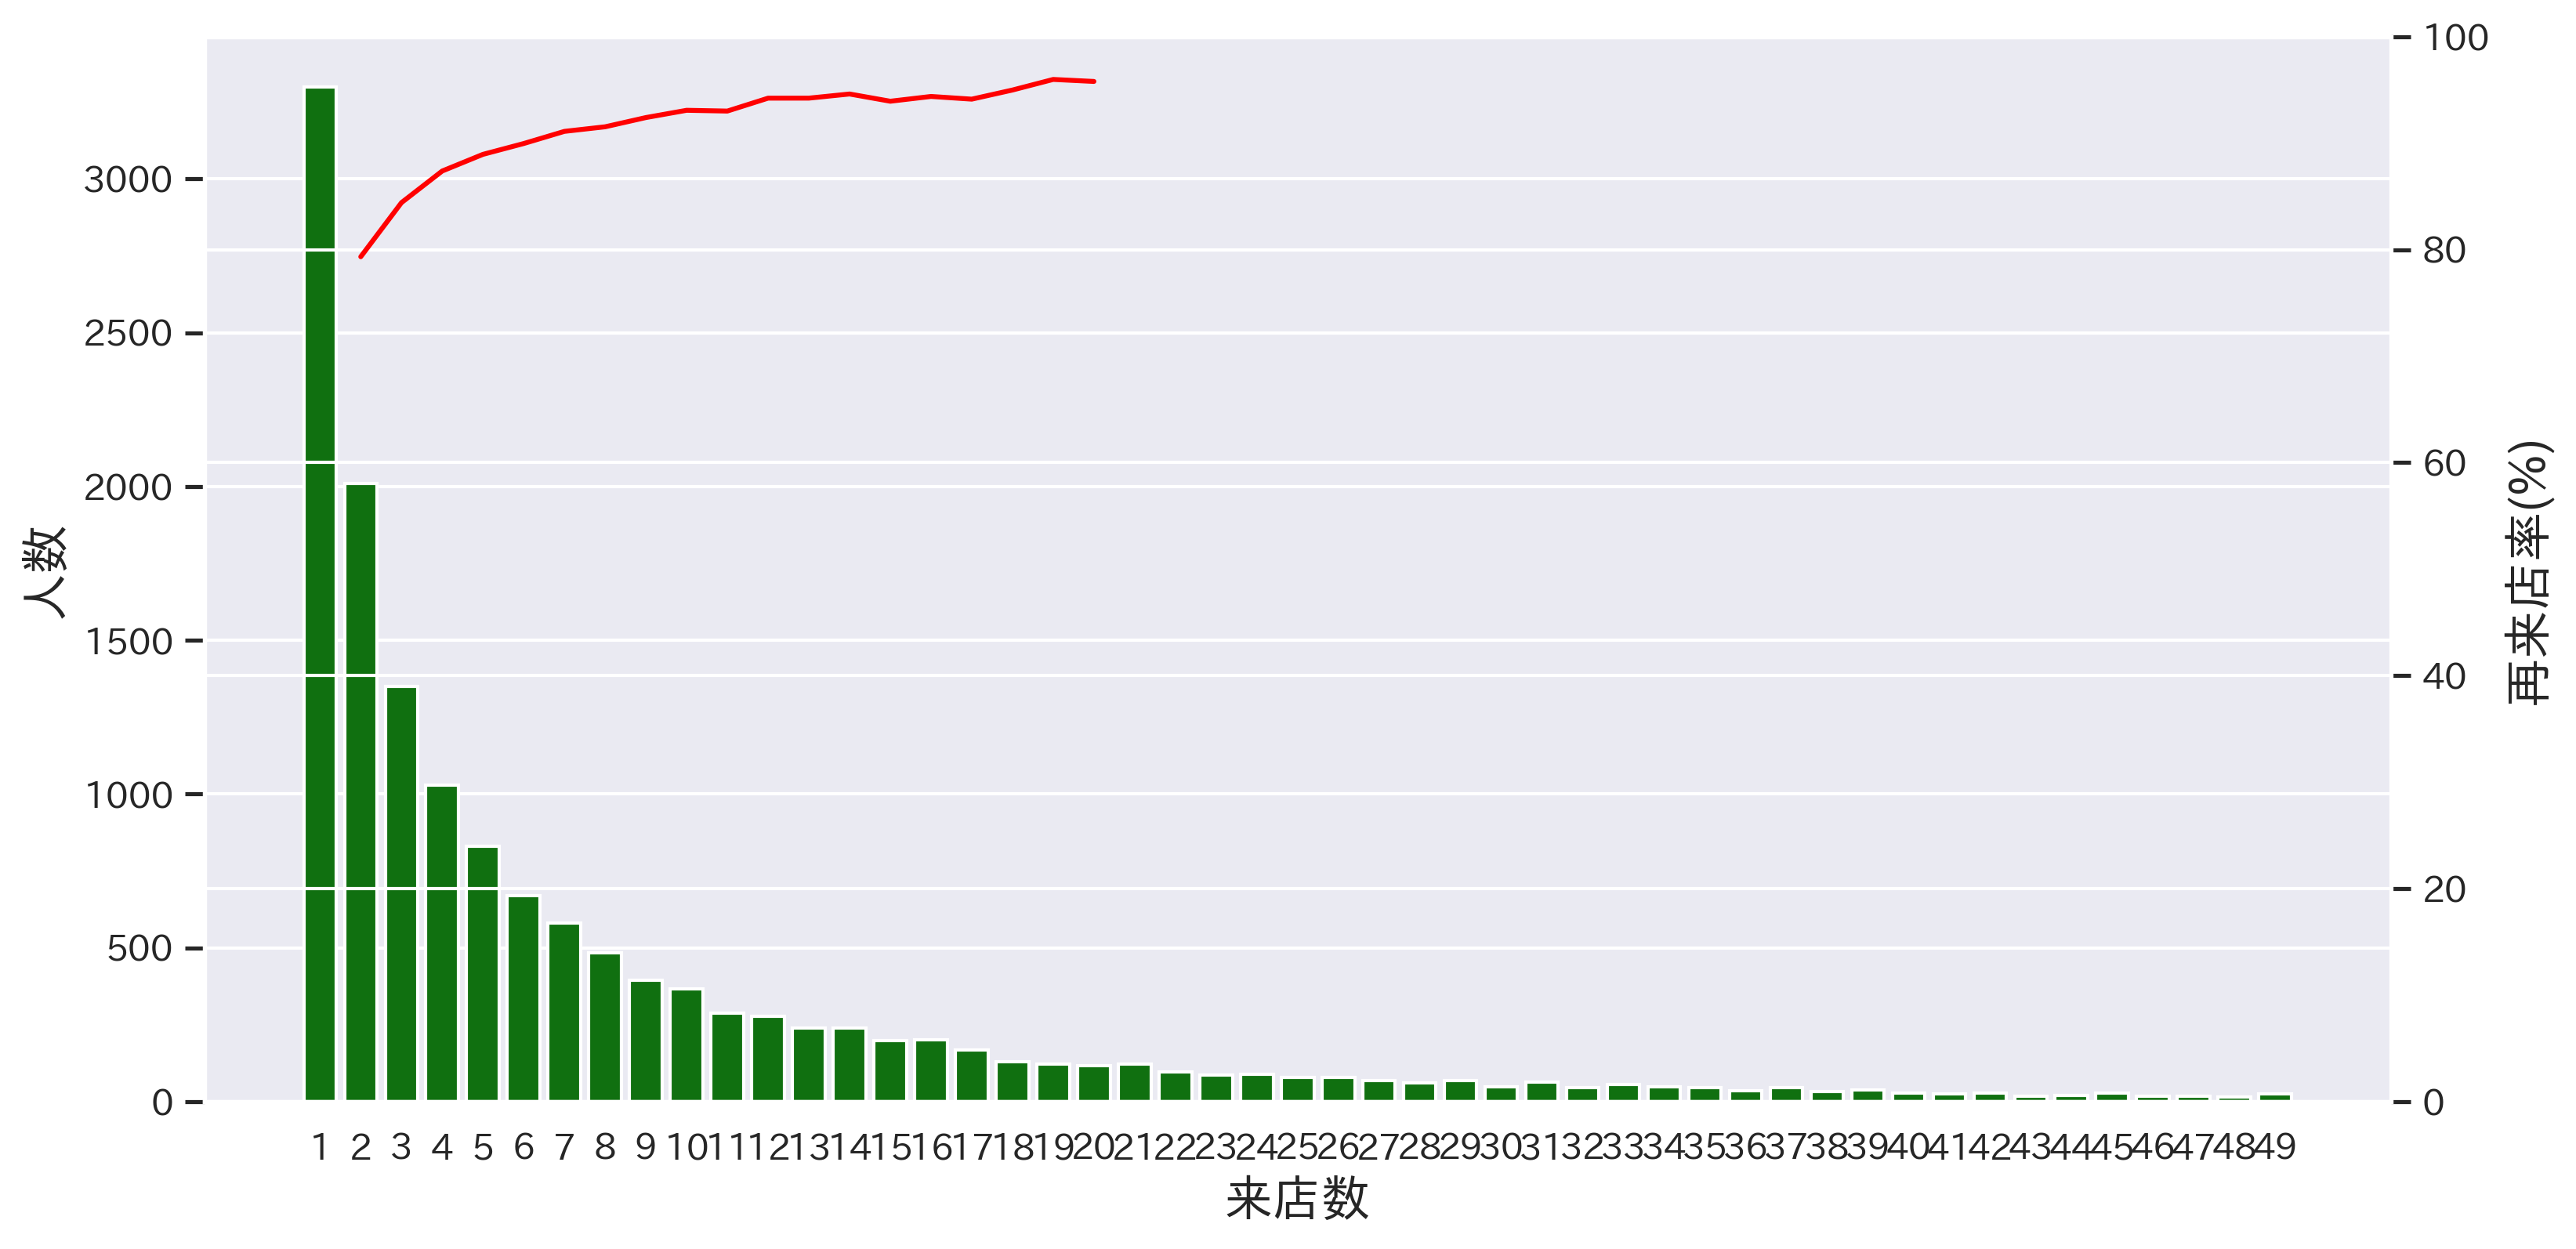

In [41]:
fig,ax = plt.subplots(figsize=(12,6), dpi = 300)
p = sns.barplot(data=df_user_txns[df_user_txns['来店数'] < 50], x="来店数", y = '人数', color= 'green')
p.set_xlabel("来店数", fontsize = 15)
p.set_ylabel("人数", fontsize = 15)
ax2 = ax.twinx()
sns.lineplot(x=list(range(1, 20)), y=ls_ratio_transition, ax = ax2, color='red')
ax2.set_ylabel('再来店率(%)', fontsize = 15)
ax2.set_ylim(0,100)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
#plt.xlabel('顧客人数')
plt.show()

In [42]:
ratio_lt_50 = df_user_txns[df_user_txns['来店数'] <= 50]['人数'].sum()/df_user_txns['人数'].sum() * 100.0
print(f'50回数以下で来店の顧客は全部の顧客の{ratio_lt_50:.2f}%')

50回数以下で来店の顧客は全部の顧客の96.96%


### ６．２　決定木を使って年齢を特徴化

In [43]:
# extract feature list
def tree_to_feature(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    features = list()    
    def recurse(node, depth, features):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            features.append(name)
            features = recurse(tree_.children_left[node], depth + 1, features)
            features = recurse(tree_.children_right[node], depth + 1, features)
        return features
    features = recurse(0, 1, features)
    return features

In [44]:
df_txn_user_cnt_txn['会員ID'].nunique()

14870

In [45]:
# split the age information into segments based on distribution 
info_split = {'男': [16.5, 33.5, 46.5], '女': [2.5, 11.5, 20.5, 54.5, 70.5, 93.5]}

### ６．３　全部のデータを特徴化

In [46]:
def AgeSegment(x, info_split):
    gender = x['Gender']
    age    = x['Age']
    idx    = next((ix for ix,x in enumerate(info_split[gender]) if x >= age), None)
    if idx == 0:
        ageSeg = f'{gender}_(MIN, {info_split[gender][idx]}]'
    elif idx is None:
        ageSeg = f'{gender}_({info_split[gender][-1]}, Max)'
    else:
        ageSeg = f'{gender}_({info_split[gender][idx-1]}, {info_split[gender][idx]}]'
    return ageSeg

In [47]:
# data preprocessing
df_txn_user_cnt_txn_gt3 = df_txn_user_cnt_txn[df_txn_user_cnt_txn['売上数'] >= 3]
print('the total customers of df_txn_user_cnt_txn_gt3 : {}'.format(df_txn_user_cnt_txn_gt3['会員ID'].nunique()) )
df_txn_user_date_gap = df_txn_daily.merge(df_txn_user_cnt_txn_gt3, on = '会員ID', how = 'inner').groupby('会員ID')['日付の差'].quantile(0.5).reset_index()
print('the total customers of df_txn_user_date_gap : {}'.format(df_txn_user_date_gap['会員ID'].nunique()) )
df_txn_user_date_gap_full = df_txn_user_date_gap.merge(df_cust_profile_t2, on = '会員ID', how = 'inner').dropna(how='any')
print('the total customers of df_txn_user_date_gap_full : {}'.format(df_txn_user_date_gap_full['会員ID'].nunique()) )

# split the Age information
df_txn_user_date_gap_full.loc[:, 'AgeSeg'] = df_txn_user_date_gap_full.apply(lambda x: AgeSegment(x, info_split), axis = 1)

# columns to use in the model, but need to be featurised first
#ls_cols = ['Gender', 'Job', 'AgeSeg']
ls_cols = ['Gender', 'AgeSeg']
data_model_pre = df_txn_user_date_gap_full.set_index('会員ID')
data_model = pd.get_dummies(data_model_pre[ls_cols],prefix= ls_cols)

# use the decision tree to select several features insteal of using all feature for clustering
data_model = data_model.merge(df_txn_user_date_gap_full[['会員ID','日付の差']], how = 'left', left_index=True, right_on = '会員ID')
data_model.set_index('会員ID', inplace = True)

# get training data
X = data_model.iloc[:, :-1].to_numpy()
Y = data_model.iloc[:, -1].to_numpy()

# build decision trees
reg_cart = DecisionTreeRegressor(max_depth=10)
reg_cart.fit(X, Y)

# select the features
ls_features = data_model.iloc[:, :-1].columns.tolist()
ls_features_sel = list(set(tree_to_feature(reg_cart, ls_features)))
data_model_sel = data_model[ls_features_sel]

the total customers of df_txn_user_cnt_txn_gt3 : 9563
the total customers of df_txn_user_date_gap : 9563
the total customers of df_txn_user_date_gap_full : 1482


### ６．４　K-Meansを使って顧客クラスタリングを行う

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fb0590c2310>
Traceback (most recent call last):
  File "/home/zhangmingming/anaconda3/envs/present/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zhangmingming/anaconda3/envs/present/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zhangmingming/anaconda3/envs/present/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zhangmingming/anaconda3/envs/present/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback fun

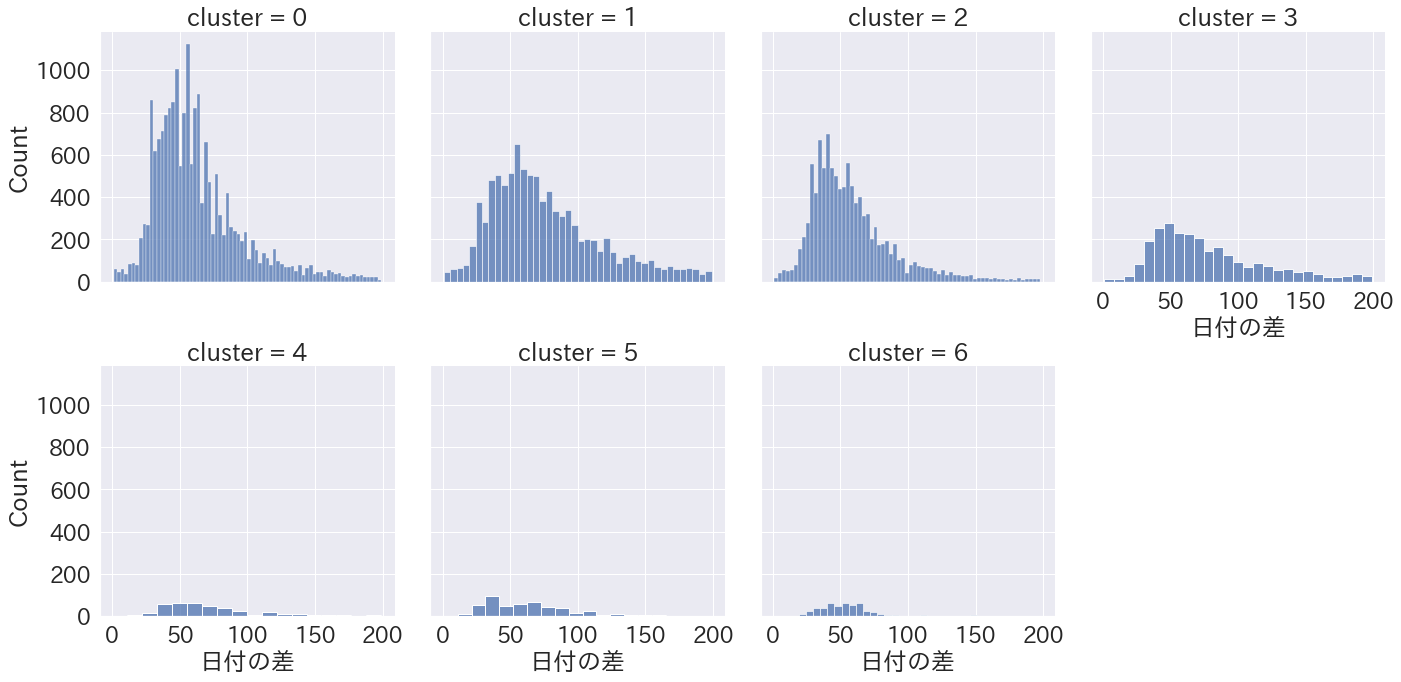

In [48]:
'''
# load model if exist 
fpath_kmeans = os.path.join(path_model, "Kmeans.pkl")
if os.path.exists(fpath_kmeans):
    with open(fpath_kmeans, "rb") as hf:
        kmeans = pickle.load(hf)
else:
    # build models
    kmeans = MiniBatchKMeans(n_clusters=9,
                    init='k-means++',
                    max_iter=300,
                    random_state=0)
    kmeans.fit(data_model_sel)

    # save model
    with open(fpath_kmeans, "wb") as hf:
        pickle.dump(kmeans, hf)
'''
kmeans = MiniBatchKMeans(n_clusters=7,
                init='k-means++',
                max_iter=300,
                random_state=0)
kmeans.fit(data_model_sel)

# クラスタリング情報の扱う
data_model_graph = data_model.copy()
data_model_graph.loc[:, 'cluster'] = kmeans.labels_.tolist()
data_model_cluster = data_model_graph[["cluster"]].reset_index()
data_model_cluster = data_model_cluster.merge(df_txn_daily, on = '会員ID', how = 'left')

#fig,ax = plt.subplots(figsize=(12,6), dpi = 300)
sns.set(font_scale = 2, font = 'IPAexGothic')
g = sns.FacetGrid(data_model_cluster[data_model_cluster['日付の差'] < 200], col="cluster", height=5, aspect=1, col_wrap=4)
#g = sns.FacetGrid(data_model, col="cluster", height=2.5, col_wrap=4)
g.map(sns.histplot, "日付の差")

# reset
sns.set(font_scale = 1, font='IPAexGothic')

In [49]:
# クラスタリングのサイズを分析します
print(data_model_graph.groupby('cluster').size().reset_index(name = '人数').sort_values(by='人数', ascending=False))
#data_model.groupby('cluster').size().reset_index().to_csv('test.csv')

   cluster   人数
0        0  516
1        1  472
2        2  279
3        3  149
4        4   32
5        5   17
6        6   17


### ６．5　顧客来店数を予測します

In [50]:
# この前の一年間の顧客来店データを利用して予測します
data_model_cluster_temp = data_model_cluster[(data_model_cluster['日付の差'] < 360)]
df_grp_bp = data_model_cluster_temp.groupby(['cluster', '日付の差']).size().reset_index(name = 'count')
df_grp_tt = data_model_cluster_temp.groupby(['cluster']).size().reset_index(name = 'count_ttl')
df_grp_bp = df_grp_bp.merge(df_grp_tt, on = 'cluster', how = 'left')
df_grp_bp.loc[:, 'pct'] = df_grp_bp['count']*1.0/df_grp_bp['count_ttl']

ls_sdate = []　　　# 時間のデータ（テキスト形式）
ls_date = []       # 時間のデータ（日付形式）
dict_pred = dict() # 予測の結果

#ーーーー モデルの初期化

#予測はじめの時間点
date_start = date(2014,1,4)
sdate_start = date_start.strftime('%Y/%m/%d')
sdate_start_pre = (date_start - timedelta(days = 360)).strftime('%Y/%m/%d')

#この前の一年間のデータを基ついて予測します
data_model_cluster_subset = data_model_cluster[(data_model_cluster['売上日'] < sdate_start)&(data_model_cluster['売上日'] > sdate_start_pre)]
#df_grp_bp_pivot = df_grp_bp.pivot_table(values='pct', columns='cluster', index= '日付の差', aggfunc='sum', fill_value=0)
cust_lst_dt = data_model_cluster_subset.groupby(['cluster', '会員ID'])['売上日'].max().reset_index()
cust_lst_dt_pop =  cust_lst_dt.groupby(['cluster', '売上日']).size().reset_index(name = 'pop')
cust_lst_dt_pop.loc[:, 'gap'] = cust_lst_dt_pop['売上日'].apply(lambda x : (date_start - datetime.strptime(x, '%Y/%m/%d').date()).days )

#この前の一年間の日毎の来店可能性を統計します
for d in range(360):
    date_cut  = date_start + timedelta(days = d)
    ls_date.append(date_cut)
    sdate_cut = date_cut.strftime('%Y/%m/%d')
    ls_sdate.append(sdate_cut)
    df_date = df_grp_bp.merge(cust_lst_dt_pop,how = 'left', left_on = ['cluster', '日付の差'], right_on = ['cluster', 'gap'])
    df_date['pop'].fillna(0, inplace = True)
    df_date.loc[:, 'pred'] = df_date['pct'] * df_date['pop']
    dict_pred[d] = dict_pred.get(d,0) + df_date['pred'].sum()
    cust_lst_dt_pop.loc[:, 'gap'] = cust_lst_dt_pop['gap'] + 1.0

#ーーーー 予測始めます

#月毎で予測の結果を更新します
for m in range(12):
    date_pcut = date_start + timedelta(days = m*30)
    sdate_start = date_pcut.strftime('%Y/%m/%d')
    sdate_start_pre = (date_pcut - timedelta(days = 30)).strftime('%Y/%m/%d')
    data_model_cluster_subset = data_model_cluster[(data_model_cluster['売上日'] < sdate_start)&(data_model_cluster['売上日'] > sdate_start_pre)]
    #df_grp_bp_pivot = df_grp_bp.pivot_table(values='pct', columns='cluster', index= '日付の差', aggfunc='sum', fill_value=0)
    cust_lst_dt = data_model_cluster_subset.groupby(['cluster', '会員ID'])['売上日'].max().reset_index()
    cust_lst_dt_pop =  cust_lst_dt.groupby(['cluster', '売上日']).size().reset_index(name = 'pop')
    cust_lst_dt_pop.loc[:, 'gap'] = cust_lst_dt_pop['売上日'].apply(lambda x : (date_pcut - datetime.strptime(x, '%Y/%m/%d').date()).days )
    for d in range(360 - m * 30):
        df_date = df_grp_bp.merge(cust_lst_dt_pop,how = 'left', left_on = ['cluster', '日付の差'], right_on = ['cluster', 'gap'])
        df_date['pop'].fillna(0, inplace = True)
        df_date.loc[:, 'pred'] = df_date['pct'] * df_date['pop']
        dict_pred[m*30 + d] = dict_pred.get(m*30 + d,0) + df_date['pred'].sum()
        cust_lst_dt_pop.loc[:, 'gap'] = cust_lst_dt_pop['gap'] + 1.0

#ーーーー 予測結果をまとめます

#実際値
ls_act = []
for dt in ls_sdate:
    df_date_pop = data_model_cluster.groupby(['cluster', '売上日']).size().reset_index(name = 'pop')
    ls_act.append(df_date_pop[(df_date_pop['売上日'] == dt)]['pop'].sum())

#予測値
ls_pred = list(dict_pred.values())
fig,ax = plt.subplots(figsize=(12,6), dpi = 300)
plt.plot_date(ls_date, ls_pred, 'b-')
plt.plot_date(ls_date, ls_act, 'r-')

#ーーーー 予測結果を評価します
print('予測結果のRMSE値は')
print(np.sqrt(mean_squared_error(ls_act, ls_pred)))

In [55]:
df_date_pop = data_model_cluster.groupby(['cluster', '売上日']).size().reset_index(name = 'pop')

In [57]:
df_date_pop = data_model_cluster.groupby([ '売上日']).size().reset_index(name = 'pop')

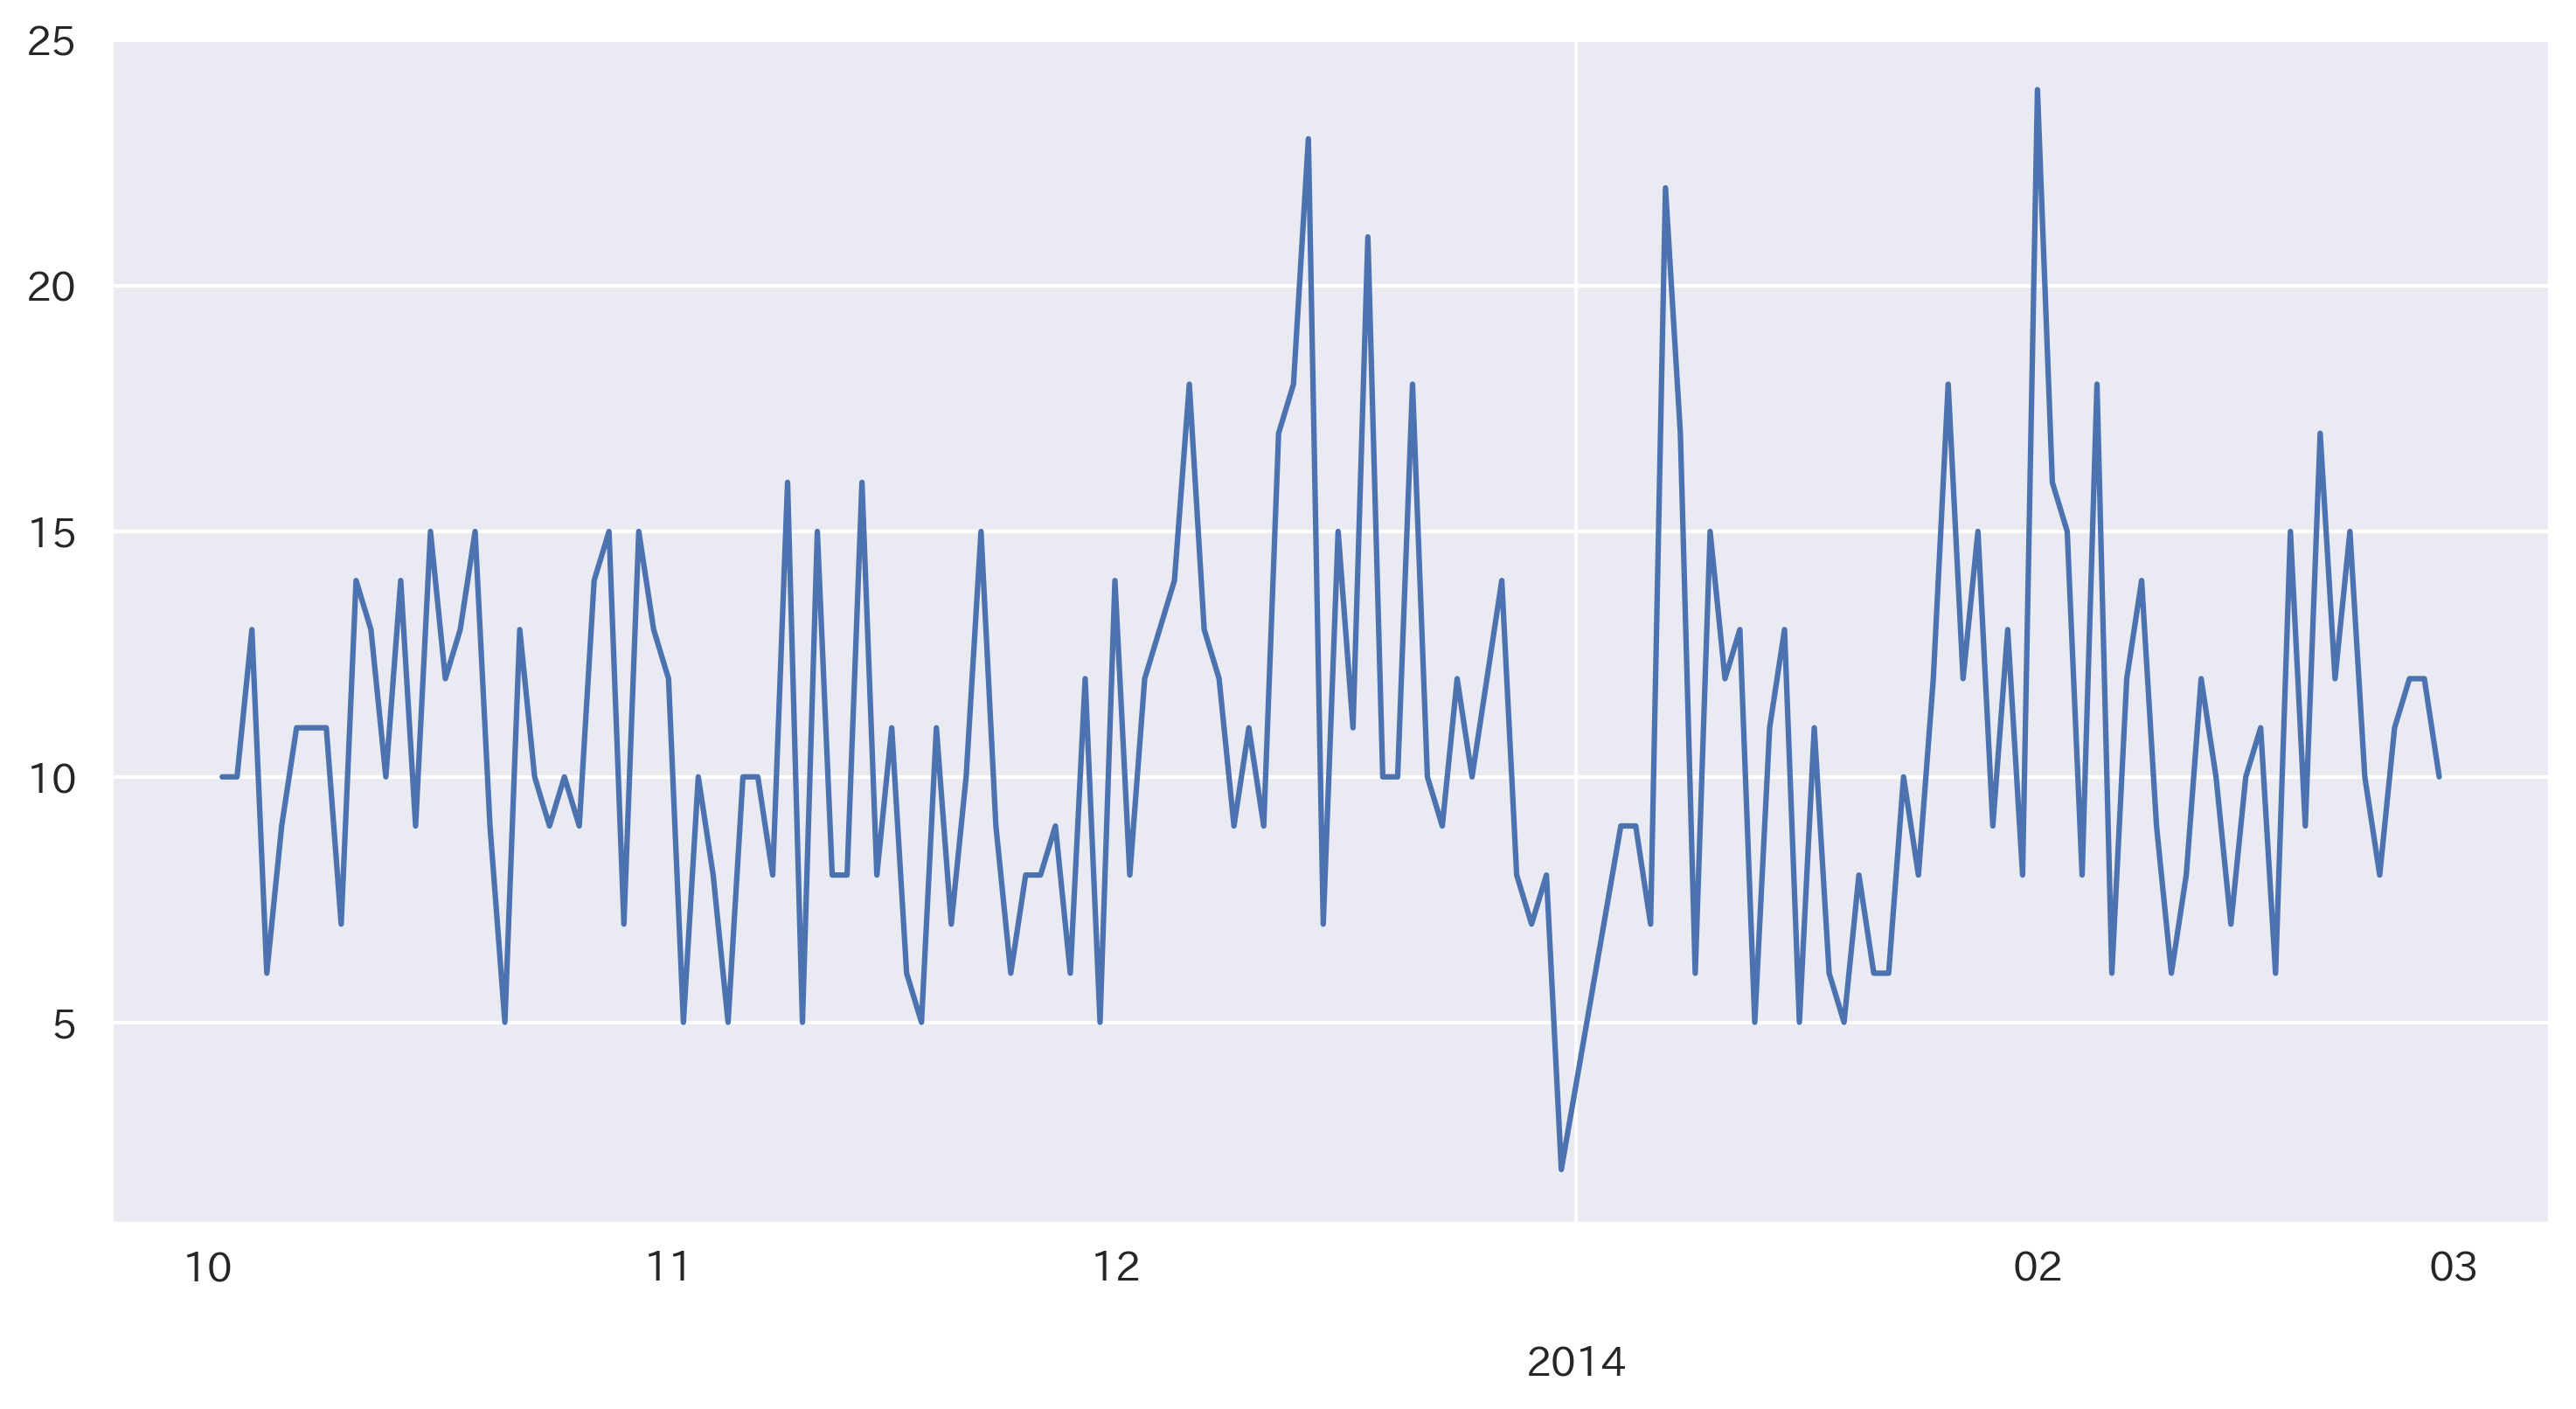

In [65]:
# format the fig
years = mdates.YearLocator()
months = mdates.MonthLocator(interval=1)
monthsFmt = mdates.DateFormatter('%m') 
yearsFmt = mdates.DateFormatter('\n\n%Y')  # add some space for the year label
fig,ax = plt.subplots(figsize=(12,6), dpi = 300)
df_date_pop_part = df_date_pop[(df_date_pop['売上日'] < '2014/03/01')&(df_date_pop['売上日'] > '2013/10/01')]
ls_dt = [mdates.date2num(datetime.strptime(dt, '%Y/%m/%d')) for dt in df_date_pop_part[ '売上日'].tolist()]
plt.plot_date(ls_dt, df_date_pop_part[ 'pop'].tolist(), 'b-')
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(monthsFmt)
#plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)

In [245]:
'''
df_date_pop = data_model_cluster.groupby(['売上日']).size().reset_index(name = 'pop')
fig,ax = plt.subplots(figsize=(12,6), dpi = 300)
df_date_pop['pop'].plot()
'''

"\ndf_date_pop = data_model_cluster.groupby(['売上日']).size().reset_index(name = 'pop')\nfig,ax = plt.subplots(figsize=(12,6), dpi = 300)\ndf_date_pop['pop'].plot()\n"

### ６．6　K-means　結果のクラスタリング画像

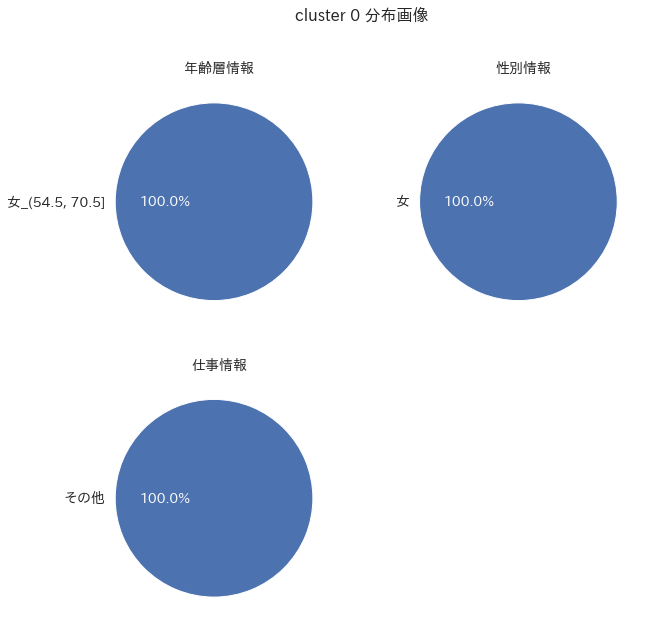

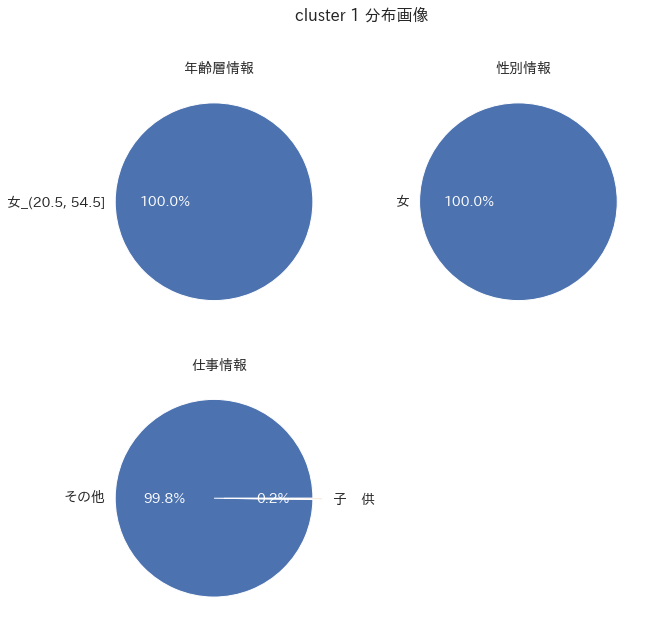

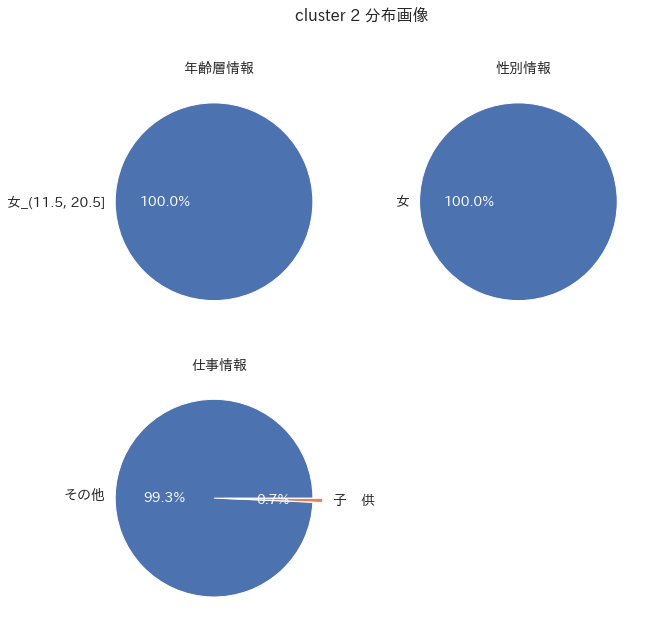

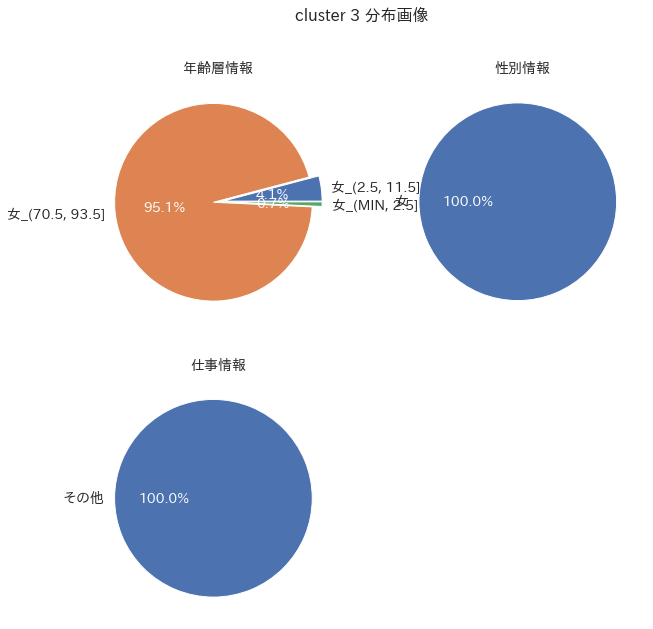

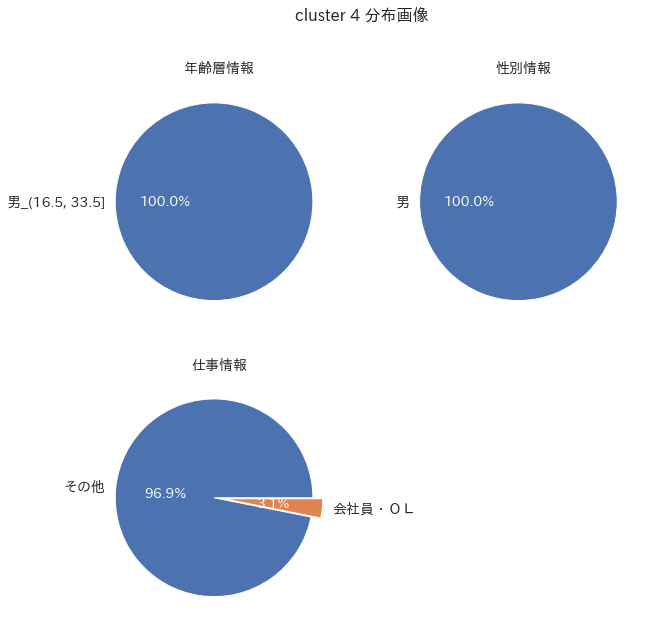

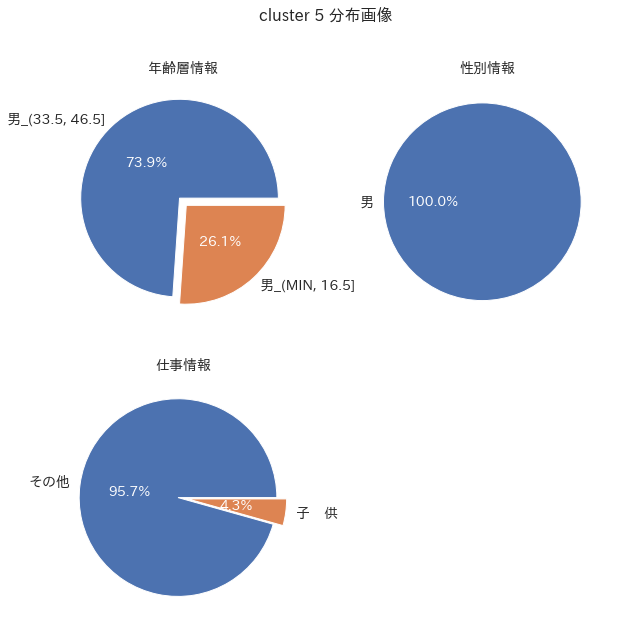

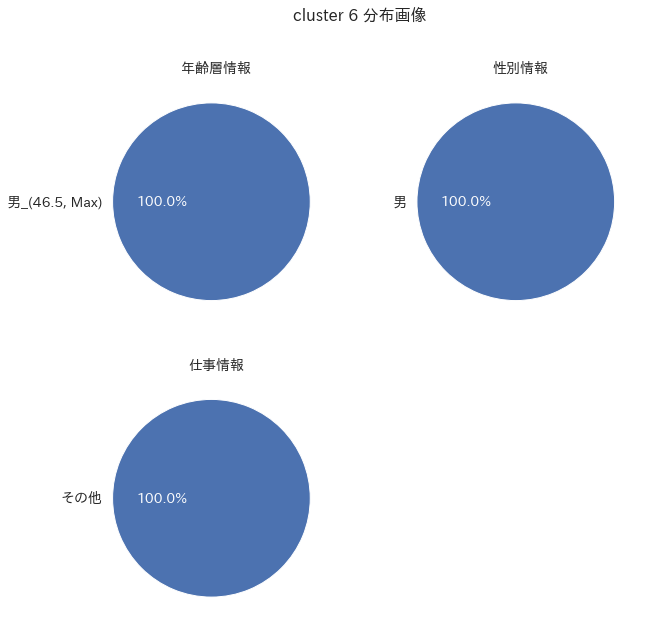

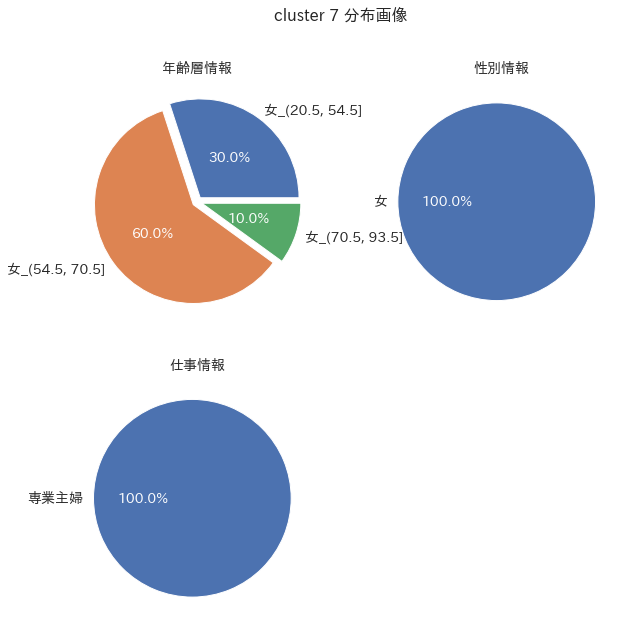

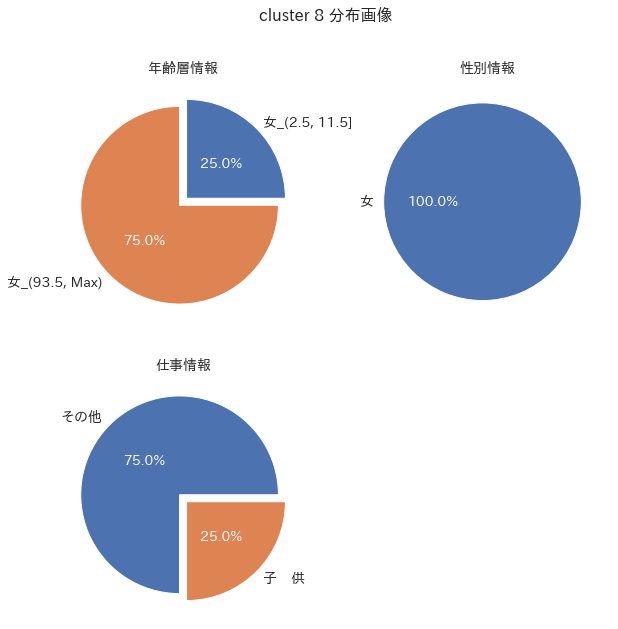

In [62]:
data_cluster_profile = data_model_graph[["cluster"]].reset_index()
data_cluster_profile = data_cluster_profile.merge(df_txn_user_date_gap_full, on = '会員ID', how = 'left')
for c in range(9):
    data_cluster_profile_0 = data_cluster_profile[data_cluster_profile['cluster']==c]

    fig, axes = plt.subplots(2,2,figsize=[10,10])

    # 年齢層
    ax1 = plt.subplot2grid((2,2),(0,0))
    info_Age = data_cluster_profile_0.groupby('AgeSeg').size().reset_index(name = '人数')# 年齢層
    _, _, autotexts = plt.pie(x=info_Age['人数'].tolist(), autopct="%.1f%%",labels=info_Age['AgeSeg'].tolist(), 
                              explode=[0.05]*info_Age.shape[0], pctdistance=0.5, textprops={'fontsize': 14})
    for autotext in autotexts:
        autotext.set_color('white')
    plt.title("年齢層情報", fontsize=14);

    # 性別
    ax2 = plt.subplot2grid((2,2),(0,1))
    info_gender = data_cluster_profile_0.groupby('Gender').size().reset_index(name = '人数')# 年齢層
    _, _, autotexts = plt.pie(x=info_gender['人数'].tolist(), autopct="%.1f%%",labels=info_gender['Gender'].tolist(), 
                              explode=[0.05]*info_gender.shape[0], pctdistance=0.5, textprops={'fontsize': 14})
    for autotext in autotexts:
        autotext.set_color('white')
    plt.title("性別情報", fontsize=14)

    # 仕事情報
    ax2 = plt.subplot2grid((2,2),(1,0))
    info_job = data_cluster_profile_0.groupby('Job').size().reset_index(name = '人数')# 年齢層
    _, _, autotexts = plt.pie(x=info_job['人数'].tolist(), autopct="%.1f%%",labels=info_job['Job'].tolist(), 
                              explode=[0.05]*info_job.shape[0], pctdistance=0.5, textprops={'fontsize': 14})
    for autotext in autotexts:
        autotext.set_color('white')
    plt.title("仕事情報", fontsize=14)

    # show the map 
    fig.delaxes(axes[1][1])
    fig.suptitle(f'cluster {c} 分布画像', fontsize=16)
    plt.savefig(f'./Model/Cluster/cluster_{c}.png')

### ６．7　クラスタリングの売上分析

In [ ]:
# 顧客クラスタリングデータを準備します
data_cluster_txn = data_model_graph[["cluster"]].reset_index()
data_cluster_txn = data_cluster_txn.merge(df_txn, on = '会員ID', how = 'left')

#### ６．７．１　クラスタリングの売上データ（日別 藤川さんのprophet )

In [ ]:
data_cluster_txn_pivot_daily = pd.pivot_table(data_cluster_txn, values='販売金額', index=['売上日'], columns=['cluster'], aggfunc=np.sum, fill_value=0)
# output file to csv
#data_cluster_txn_pivot_daily.to_csv('./Data/Cluster/transaction_cluster_daily.csv')

#### ６．７．２　クラスタリングの売上データ（月別）

In [ ]:
data_cluster_txn.loc[:, '売上月'] = data_cluster_txn.apply(lambda x: date(datetime.strptime(x['売上日'], '%Y/%m/%d').year, datetime.strptime(x['売上日'], '%Y/%m/%d').month, 1),axis = 1)
data_cluster_txn_pivot = pd.pivot_table(data_cluster_txn, values='販売金額', index=['売上月'], columns=['cluster'], aggfunc=np.sum, fill_value=0)

In [ ]:
sns.set_theme()
fig,ax = plt.subplots(figsize=(12,6), dpi = 300)
plt.stackplot(data_cluster_txn_pivot.index.tolist(),data_cluster_txn_pivot.to_numpy().transpose(1,0), labels=data_cluster_txn_pivot.columns.values)
plt.legend(loc='upper left')
#plt.ylim((0,20000))
plt.show()

### 7．顧客の第２回のクラスタリング

In [ ]:
data_model_V2 = data_model.merge(df_txn_amt_cust[['会員ID','pct_rank_amt']], left_index= True, right_on = '会員ID', how = 'left')
data_model_V2 = data_model_V2.merge(df_txn_freq_cust[['会員ID','pct_rank_freq']], on = '会員ID', how = 'left')
data_model_V2 = data_model_V2.set_index('日付の差').reset_index().set_index('会員ID')
data_model_V2.loc[:,'日付の差'] = data_model_V2['日付の差']/300.0

In [ ]:
# get training data
X = data_model_V2.iloc[:, 1:].to_numpy()
Y = data_model_V2.iloc[:, 0].to_numpy()

# build decision trees
reg_cart = DecisionTreeRegressor(max_depth=10)
reg_cart.fit(X, Y)

# select the features
ls_features = data_model_V2.iloc[:, 1:].columns.tolist()
ls_features_sel = list(set(tree_to_feature(reg_cart, ls_features)))
data_model_sel = data_model_V2[ls_features_sel + ['日付の差']]

In [ ]:
# load model if exist 
fpath_kmeans = os.path.join(path_model, "Kmeans_V2.pkl")
if os.path.exists(fpath_kmeans):
    with open(fpath_kmeans, "rb") as hf:
        kmeans = pickle.load(hf)
else:
    # build models
    kmeans = MiniBatchKMeans(n_clusters=9,
                    init='k-means++',
                    max_iter=300,
                    random_state=0)
    kmeans.fit(data_model_sel)

    # save model
    with open(fpath_kmeans, "wb") as hf:
        pickle.dump(kmeans, hf)

In [ ]:
# クラスタリング情報の扱う
data_model_graph = data_model_V2.copy()
data_model_graph.loc[:, 'cluster'] = kmeans.labels_.tolist()
data_model_cluster = data_model_graph[["cluster"]].reset_index()
data_model_cluster = data_model_cluster.merge(df_txn_daily, on = '会員ID', how = 'left')

#fig,ax = plt.subplots(figsize=(12,6), dpi = 300)
sns.set(font_scale = 2, font = 'IPAexGothic')
plt.rcParams['axes.facecolor'] = 'white'
g = sns.FacetGrid(data_model_cluster[data_model_cluster['日付の差'] < 300], col="cluster", height=5, aspect=1, col_wrap=4)
#g = sns.FacetGrid(data_model, col="cluster", height=2.5, col_wrap=4)
g.map(sns.histplot, "日付の差")

# reset
sns.set(font_scale = 1, font='IPAexGothic')

In [ ]:
# クラスタリングのサイズを分析します
print(data_model_graph.groupby('cluster').size().reset_index(name = '人数').sort_values(by='人数', ascending=False))
#data_model.groupby('cluster').size().reset_index().to_csv('test.csv')

In [ ]:
# should use transaction data instead of user data 
data_cluster_profile = data_model_graph[["cluster",'pct_rank_amt','日付の差','pct_rank_freq']].reset_index()
data_cluster_profile = data_cluster_profile.merge(df_txn_amt_cust[['会員ID','Amount']], on = '会員ID', how = 'left')
data_cluster_profile = data_cluster_profile.merge(df_cust_profile_t2, on = '会員ID', how = 'left')
#data_cluster_profile = data_cluster_profile.merge(df_txn_daily, on = '会員ID', how = 'left')
#data_cluster_profile = data_cluster_profile[data_cluster_profile['日付の差'] < 200]

# get plot
plt.rcParams['axes.facecolor'] = 'white'
fig,ax = plt.subplots(figsize=(12,6), dpi = 300)
for i in range(9):
    plt.scatter(data_cluster_profile[data_cluster_profile['cluster'] == i ]['Age'], data_cluster_profile[data_cluster_profile['cluster'] == i ]['Amount'], label = f'cluster_{i}')
plt.legend()
plt.xlabel('年齢')
plt.ylabel('売上高')
plt.show()

In [ ]:
max_amount = data_cluster_profile['Amount'].max()

In [ ]:
sns.set(font_scale = 1, font='IPAexGothic')
plt.rcParams['axes.facecolor'] = 'white'
for c in range(9):
    data_cluster_profile_0 = data_cluster_profile[data_cluster_profile['cluster']==c]

    fig, axes = plt.subplots(1, 4, tight_layout=True, figsize=(12,6), dpi = 300)

    # 年齢層
    axes[0].hist(data_cluster_profile_0['Age'].tolist(), bins=10)
    axes[0].set_title("年齢情報")
    
    # 性別
    info_gender = data_cluster_profile_0.groupby('Gender').size().reset_index(name = '人数')# 年齢層
    _, _, autotexts = axes[1].pie(x=info_gender['人数'].tolist(), autopct="%.1f%%",labels=info_gender['Gender'].tolist(), 
                              explode=[0.05]*info_gender.shape[0], pctdistance=0.5, textprops={'fontsize': 14})
    for autotext in autotexts:
        autotext.set_color('white')
    axes[1].set_title("性別情報")
    
    # 仕事情報
    info_job = data_cluster_profile_0.groupby('Job').size().reset_index(name = '人数')# 年齢層
    _, _, autotexts = axes[2].pie(x=info_job['人数'].tolist(), autopct="%.1f%%",labels=info_job['Job'].tolist(), 
                              explode=[0.05]*info_job.shape[0], pctdistance=0.5, textprops={'fontsize': 14})
    for autotext in autotexts:
        autotext.set_color('white')
    axes[2].set_title("仕事情報")
    
    # 仕事情報
    axes[3].hist(data_cluster_profile_0['Amount'].tolist(), bins=10)
    axes[3].set_title("売上高情報")
    #axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation=90, ha = 'right')
    axes[3].tick_params(axis='x', labelrotation=45)
    
    # show the map 
    #fig.delaxes(axes[1][1])
    fig.suptitle(f'cluster {c} 分布画像', fontsize=16)
    plt.savefig(f'./Model/Cluster_V2/cluster_{c}.png')
    #plt.show()